In [1]:
import logging
import os
import sys
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Any, Tuple
from zipfile import ZipFile

import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.constants as sconst
import seaborn as sns
from IPython.display import display

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))


import src.utils.custom_log as custom_log
from src.utils.Csv import Csv
from src.utils.iso18571 import rating_iso_18571_short
from src.utils.olc import get_olc
from src.utils.set_rcparams import set_rcparams
from src.utils.UnifySignal import UnifySignal

os.chdir(project_dir)
LOG = logging.getLogger(__name__)
custom_log.init_logger(logging.INFO)
LOG.info("Start in %s", Path().cwd())

set_rcparams()

2025-01-03 20:49:05,078     INFO  MainProcess  MainThread Start in /root/py_projects/aihiii
2025-01-03 20:49:05,080     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2025-01-03 20:49:05,239     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle


In [2]:
FIG_DIR = project_dir / "reports" / "figures" / notebook_path.stem
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
with ZipFile(Path("/mnt/q/Val_Chain_Sims/AB_Testing") / "000_Base_Model" / "extracted.csv.zip") as z:
    df = (
        pl.scan_csv(z.read("extracted.csv"))
        .with_columns(
            pl.col("Assembly").replace(
                old=["Assemblies_1", "Assemblies_2", "Assemblies_3", "Assemblies_4"], new=["SP 48", "DP 48", "SP 96", "DP 96"]
            )
        )
        .with_columns(pl.col("Channel").str.replace("H350", "??50"))
        .with_columns(pl.col("Channel").str.replace("TH50", "??50"))
        .with_columns(pl.col("Configuration").str.slice(4))
        .with_columns(pl.col("Configuration").str.replace("_", " "))
        .with_columns(
            pl.col("Case").replace(
                old=["Moderate_Overlap_Left", "Moderate_Overlap_Right"], new=["Moderate Overlap Left", "Moderate Overlap Right"]
            )
        )
        .select(["Time", "Value", "Channel", "Source", "Assembly", "Configuration", "Case"])
        .collect()
    )
df
# pl.read_csv(ZipFile(Path("/mnt/q/Val_Chain_Sims/AB_Testing") / "000_Base_Model" / "extracted.csv.zip").read("extracted.csv"))

Time,Value,Channel,Source,Assembly,Configuration,Case
f64,f64,str,str,str,str,str
0.0,15.5587,"""00COG00000VH00VEXD""","""CAE THI""","""SP 48""","""Base Model""","""Full Frontal"""
0.1,15.5586,"""00COG00000VH00VEXD""","""CAE THI""","""SP 48""","""Base Model""","""Full Frontal"""
0.2,15.5584,"""00COG00000VH00VEXD""","""CAE THI""","""SP 48""","""Base Model""","""Full Frontal"""
0.3,15.5583,"""00COG00000VH00VEXD""","""CAE THI""","""SP 48""","""Base Model""","""Full Frontal"""
0.4,15.5582,"""00COG00000VH00VEXD""","""CAE THI""","""SP 48""","""Base Model""","""Full Frontal"""
…,…,…,…,…,…,…
139.6,-22.4571,"""03PELVLOC0??50DSZD""","""CAE THI""","""DP 96""","""Base Model""","""Oblique Right"""
139.7,-22.4549,"""03PELVLOC0??50DSZD""","""CAE THI""","""DP 96""","""Base Model""","""Oblique Right"""
139.8,-22.4529,"""03PELVLOC0??50DSZD""","""CAE THI""","""DP 96""","""Base Model""","""Oblique Right"""


# Get Data

In [3]:
# read report data
# DB_REPORT: pd.DataFrame = csv.read()
REPORT_ASS = ["1: Hardware-model Report (Singh et al. 2018a,b)", "2: FE-model Report (Singh et al. 2018a,b)"]

with ZipFile(Path("/mnt/q/Val_Chain_Sims/From_Reports") / "extracted.csv.zip") as z:
    DB_REPORT = (
        pl.scan_csv(z.read("extracted.csv"))
        .with_columns(pl.col("Channel").str.replace("TH50", "??50"))
        .with_columns(pl.col("Source").replace(old=["CAE NHTSA", "Test NHTSA"], new=[REPORT_ASS[1], REPORT_ASS[0]]))
        .with_columns(
            pl.col("Case").replace(
                old=["Moderate_Overlap_Left", "Moderate_Overlap_Right", "Full Frontal", "Oblique Right", "Oblique Left"],
                new=["ODB-L", "ODB-R", "FWB", "OMDB-R", "OMDB-L"],
            )
        )
        .select(["Time", "Value", "Channel", "Source", "Case"])
        .collect()
    ).to_pandas()


display(DB_REPORT)

,Time,Value,Channel,Source,Case
0,1.0,-0.0454,00COG00000VH00ACXD,"2: FE-model Report (Singh et al. 2018a,b)",FWB
1,2.0,0.2117,00COG00000VH00ACXD,"2: FE-model Report (Singh et al. 2018a,b)",FWB
2,3.0,0.4767,00COG00000VH00ACXD,"2: FE-model Report (Singh et al. 2018a,b)",FWB
3,4.0,0.6952,00COG00000VH00ACXD,"2: FE-model Report (Singh et al. 2018a,b)",FWB
4,5.0,0.6031,00COG00000VH00ACXD,"2: FE-model Report (Singh et al. 2018a,b)",FWB
...,...,...,...,...,...
16953,135.0,14.7103,00COG00000VH00VERD,"1: Hardware-model Report (Singh et al. 2018a,b)",OMDB-R
16954,136.0,14.7095,00COG00000VH00VERD,"1: Hardware-model Report (Singh et al. 2018a,b)",OMDB-R
16955,137.0,14.7089,00COG00000VH00VERD,"1: Hardware-model Report (Singh et al. 2018a,b)",OMDB-R
16956,138.0,14.7082,00COG00000VH00VERD,"1: Hardware-model Report (Singh et al. 2018a,b)",OMDB-R


In [4]:
sorted(DB_REPORT["Channel"].unique())

['00COG00000VH00ACRD',
 '00COG00000VH00ACXD',
 '00COG00000VH00ACYD',
 '00COG00000VH00VERD',
 '00COG00000VH00VEXD',
 '00COG00000VH00VEYD',
 '00FRONT000VH00DSRD',
 '01BELTB300??50FORD',
 '01FEMRLE00??50FORD',
 '01FEMRRI00??50FORD',
 '01HEAD0000??50ACRD',
 '01HEAD0000??50ACXD',
 '01HEAD0000??50ACYD',
 '01HEAD0000??50ACZD',
 '01PELV0000??50ACRD',
 '01PELV0000??50ACXD',
 '01PELV0000??50ACYD',
 '01PELV0000??50ACZD',
 '03BELTB300??50FORD',
 '03FEMRLE00??50FORD',
 '03FEMRRI00??50FORD',
 '03HEAD0000??50ACRD',
 '03HEAD0000??50ACXD',
 '03HEAD0000??50ACYD',
 '03HEAD0000??50ACZD',
 '03PELV0000??50ACRD',
 '03PELV0000??50ACXD',
 '03PELV0000??50ACYD',
 '03PELV0000??50ACZD']

In [5]:
def get_new_cae(model: str = "000_Base_Model"):
    with ZipFile(Path("/mnt/q/Val_Chain_Sims/AB_Testing") / model / "extracted.csv.zip") as z:
        df = (
            pl.scan_csv(z.read("extracted.csv"))
            .with_columns(
                pl.col("Assembly").replace(
                    old=["Assemblies_1", "Assemblies_2", "Assemblies_3", "Assemblies_4"], new=["SP 48", "DP 48", "SP 96", "DP 96"]
                )
            )
            .with_columns(pl.col("Channel").str.replace("H350", "??50"))
            .with_columns(pl.col("Channel").str.replace("TH50", "??50"))
            .with_columns(pl.col("Configuration").str.slice(4))
            .with_columns(pl.col("Configuration").str.replace("_", " "))
            .with_columns(
                pl.col("Case").replace(
                    old=["Moderate_Overlap_Left", "Moderate_Overlap_Right", "Full Frontal", "Oblique Right", "Oblique Left"],
                    new=["ODB-L", "ODB-R", "FWB", "OMDB-R", "OMDB-L"],
                )
            )
            .select(["Time", "Value", "Channel", "Source", "Assembly", "Configuration", "Case", "Side"])
            .collect()
        )
    return df.to_pandas()


get_new_cae()

,Time,Value,Channel,Source,Assembly,Configuration,Case,Side
0,0.0,15.5587,00COG00000VH00VEXD,CAE THI,SP 48,Base Model,FWB,None
1,0.1,15.5586,00COG00000VH00VEXD,CAE THI,SP 48,Base Model,FWB,None
2,0.2,15.5584,00COG00000VH00VEXD,CAE THI,SP 48,Base Model,FWB,None
3,0.3,15.5583,00COG00000VH00VEXD,CAE THI,SP 48,Base Model,FWB,None
4,0.4,15.5582,00COG00000VH00VEXD,CAE THI,SP 48,Base Model,FWB,None
...,...,...,...,...,...,...,...,...
8069755,139.6,-22.4571,03PELVLOC0??50DSZD,CAE THI,DP 96,Base Model,OMDB-R,None
8069756,139.7,-22.4549,03PELVLOC0??50DSZD,CAE THI,DP 96,Base Model,OMDB-R,None
8069757,139.8,-22.4529,03PELVLOC0??50DSZD,CAE THI,DP 96,Base Model,OMDB-R,None
8069758,139.9,-22.4511,03PELVLOC0??50DSZD,CAE THI,DP 96,Base Model,OMDB-R,None


# Plot

In [6]:
UNIFIER = UnifySignal(target_tend_ms=130, target_sampling_rate_ms=0.1, target_tstart_ms=0)

In [7]:
CS_REPORT = ["dimgray", "royalblue"]
NEW_CAES = ["orchid", "cadetblue", "olive"]
WIDTH = 448.13095 / 72 - 0.2
LSS = ["-", ":", "-.", "--"]


def add_textbox(ax, j: int, f1: str, f2: str, iso: float):
    bbox = lambda iso: dict(
        boxstyle="round",
        facecolor="forestgreen" if iso > 0.94 else "yellowgreen" if iso > 0.8 else "orange" if iso > 0.58 else "salmon",
        alpha=0.5,
        edgecolor="white",
        ls="",
        pad=0.1,
    )

    ax.text(
        0.01,
        0.95 - j * 0.1,
        f"{f1} vs {f2}: {iso:.2f}",
        transform=ax.transAxes,
        verticalalignment="center",
        bbox=bbox(iso),
        size="small",
    )

2025-01-03 21:34:54,908     INFO  MainProcess  MainThread maxp pruned
2025-01-03 21:34:54,911     INFO  MainProcess  MainThread cmap pruned
2025-01-03 21:34:54,912     INFO  MainProcess  MainThread post pruned
2025-01-03 21:34:54,913     INFO  MainProcess  MainThread FFTM dropped
2025-01-03 21:34:54,916     INFO  MainProcess  MainThread GPOS pruned
2025-01-03 21:34:54,918     INFO  MainProcess  MainThread GSUB pruned
2025-01-03 21:34:54,923     INFO  MainProcess  MainThread glyf pruned
2025-01-03 21:34:54,925     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-03 21:34:54,926     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-03 21:34:54,927     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 21 glyphs before
2025-01-03 21:34:54,928     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L', 'O', 'R', 'T', 'V', 'X', 'Y', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-03 21:34:54,930   

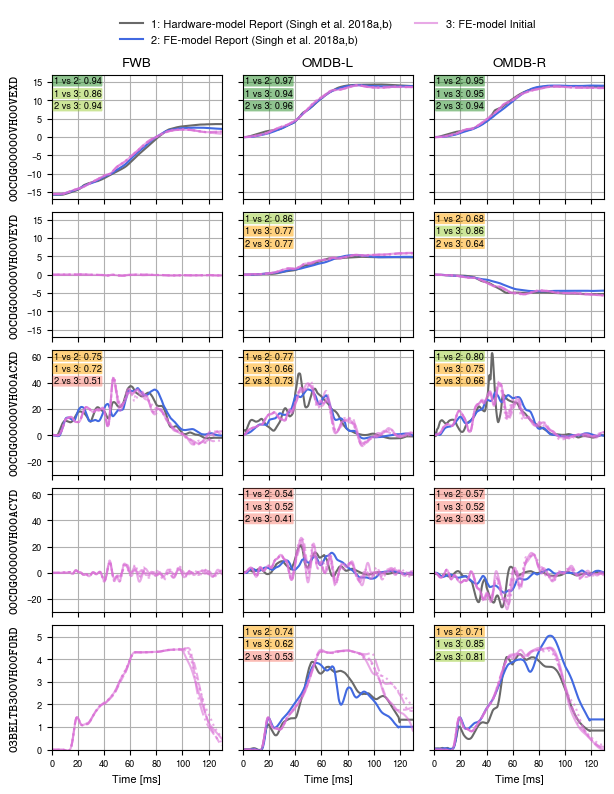

In [17]:
def plot_boundary():
    channels = ["00COG00000VH00VEXD", "00COG00000VH00VEYD", "00COG00000VH00ACXD", "00COG00000VH00ACYD", "03BELTB300VH00FORD"]
    cases = ["FWB", "OMDB-L", "OMDB-R"]

    plots = [[f"{channel}${case}" for case in cases] for channel in channels]
    plots = [["none"] * len(cases), *plots]

    y_ranges = {1: [-17, 17], 2: [-17, 17], 3: [-30, 65], 4: [-30, 65], 5: [0, 5.5]}

    db_cae = get_new_cae(model="000_Base_Model")

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=False,
        layout="constrained",
        height_ratios=[0.01, *([1] * len(channels))],
    )

    for col, case in enumerate(cases):
        for row, channel in enumerate(channels):
            field = f"{channel}${case}"

            # report data
            chh = f"{channel[:10]}??50{channel[14:-1]}D" if channel.startswith("03BELTB3") else channel
            report = DB_REPORT[DB_REPORT["Channel"].eq(chh) & DB_REPORT["Case"].eq(case)]
            report_ch = {}
            for i, ass in enumerate(REPORT_ASS):
                report2 = report[report["Source"].eq(ass)]
                flip = (
                    -1
                    if (chh == "00COG00000VH00VEXD" and case != "FWB")
                    or (chh == "00COG00000VH00ACXD")
                    or (chh == "00COG00000VH00VEYD" and case == "OMDB-L")
                    or (chh == "00COG00000VH00ACYD" and case == "OMDB-R")
                    else 1
                )

                if report2.shape[0]:
                    report_ch[ass] = UNIFIER.unify(db=report2[["Time", "Value"]].set_index("Time").dropna() * flip)["Value"]
                    ax[field].plot(report_ch[ass].index, report_ch[ass], label=ass, c=CS_REPORT[i])

            if REPORT_ASS[0] in report_ch and REPORT_ASS[1] in report_ch:
                iso_report = rating_iso_18571_short(
                    signal_ref=report_ch[REPORT_ASS[0]].loc[20:120].values,
                    signal_comp=report_ch[REPORT_ASS[1]].loc[20:120].values,
                )
            else:
                iso_report = None

            # cae data
            cae = db_cae[
                db_cae["Channel"].eq(channel) & db_cae["Case"].eq(case) & (db_cae["Side"].eq("PA") | db_cae["Side"].isna())
            ]
            flip_2 = (
                -1
                if (
                    (case == "OMDB-L" and channel == "00COG00000VH00ACYD")
                    or (case == "OMDB-R" and channel == "00COG00000VH00VEYD")
                    or (case == "FWB" and channel == "00COG00000VH00VEXD")
                )
                else 1
            )
            cae.loc[:, "Value"] *= flip * flip_2

            # plot single curves
            isos = defaultdict(list)
            for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")
                test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                ax[field].plot(
                    test.index, test, c=NEW_CAES[0], ls=LSS[j], label="3: FE-model Initial" if j == 0 else "", alpha=0.6
                )

                for ass in report_ch.keys():
                    isos[ass].append(
                        rating_iso_18571_short(signal_ref=report_ch[ass].loc[20:120].values, signal_comp=test.loc[20:120].values)
                    )

            if iso_report is not None:
                add_textbox(
                    ax=ax[field],
                    j=0,
                    f1=REPORT_ASS[0][0],
                    f2=REPORT_ASS[1][0],
                    iso=iso_report,
                )
            for j, ass in enumerate(isos.keys(), 1):
                if isos[ass]:
                    add_textbox(
                        ax=ax[field],
                        j=j,
                        f1=ass[0],
                        f2="3",
                        iso=np.median(isos[ass]),
                    )

            # format
            if row == 0:
                ax[field].set_title(case)
            if col == 0:
                ax[field].set_ylabel(channel, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
                # ax[field].annotate(units[row], (-0.25, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")
            ax[field].set_ylim(y_ranges[row + 1])
            if col != 0:
                ax[field].set_yticklabels([])
            if row == 4:
                ax[field].set_xlabel("Time [ms]")
            if "VE" in channel:
                ax[field].set_yticks(np.arange(-15, 16, 5))
            ax[field].grid()
            ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["00COG00000VH00ACYD$OMDB-L"].get_legend_handles_labels(), loc="upper center", ncol=2)

    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.3 * WIDTH)
    fig.savefig(FIG_DIR / "base_model_pulse_b3.pdf")


plot_boundary()

2024-12-18 00:56:52,867     INFO  MainProcess  MainThread maxp pruned
2024-12-18 00:56:52,870     INFO  MainProcess  MainThread cmap pruned
2024-12-18 00:56:52,872     INFO  MainProcess  MainThread post pruned
2024-12-18 00:56:52,873     INFO  MainProcess  MainThread FFTM dropped
2024-12-18 00:56:52,875     INFO  MainProcess  MainThread GPOS pruned
2024-12-18 00:56:52,877     INFO  MainProcess  MainThread GSUB pruned
2024-12-18 00:56:52,880     INFO  MainProcess  MainThread glyf pruned
2024-12-18 00:56:52,881     INFO  MainProcess  MainThread Added gid0 to subset
2024-12-18 00:56:52,882     INFO  MainProcess  MainThread Added first four glyphs to subset
2024-12-18 00:56:52,882     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2024-12-18 00:56:52,883     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'L', 'P', 'R', 'T', 'V', 'X', 'Y', 'Z', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2024-12-18 00:56:52,884     

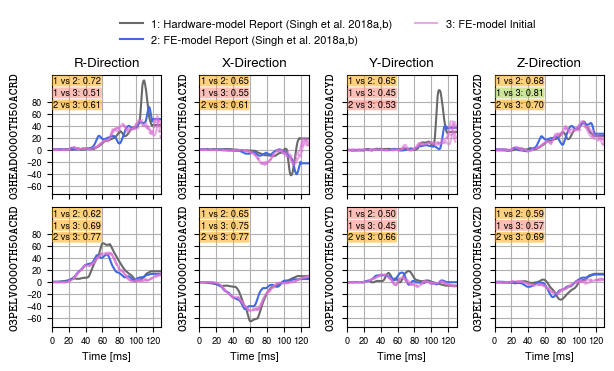

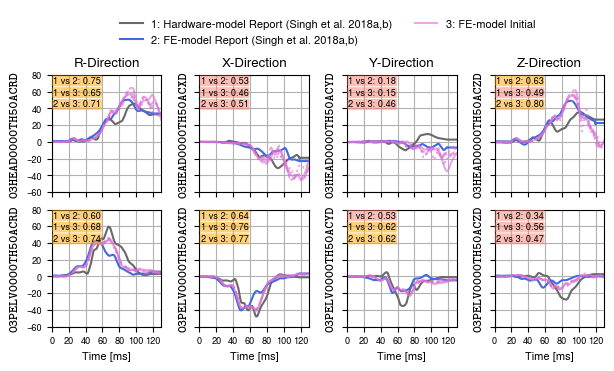

In [24]:
def plot_occupant(case):
    s = "03"

    plots = [
        [f"{s}{part}0000??50ACRD", f"{s}{part}0000??50ACXD", f"{s}{part}0000??50ACYD", f"{s}{part}0000??50ACZD"]
        for part in ["HEAD", "PELV"]
    ]
    plots = [["none"] * 4, *plots]

    db_cae = get_new_cae(model="000_Base_Model")

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=True,
        layout="constrained",
        height_ratios=[0.01, *([1] * 2)],
    )

    for field in sum(plots, []):
        # plot report data
        report = DB_REPORT[DB_REPORT["Channel"].eq(field) & DB_REPORT["Case"].eq(case)]
        flip = -1 if "HEAD0000??50ACX" in field or "HEAD0000??50ACZ" in field else 1

        report_ch = {}
        for i, ass in enumerate(REPORT_ASS):
            report2 = report[report["Source"].eq(ass)]

            if report2.shape[0]:
                report_ch[ass] = UNIFIER.unify(db=report2[["Time", "Value"]].set_index("Time").dropna() * flip)["Value"]
                ax[field].plot(report_ch[ass].index, report_ch[ass], label=ass, c=CS_REPORT[i])

        if REPORT_ASS[0] in report_ch and REPORT_ASS[1] in report_ch:
            iso_report = rating_iso_18571_short(
                signal_ref=report_ch[REPORT_ASS[0]].loc[20:120].values,
                signal_comp=report_ch[REPORT_ASS[1]].loc[20:120].values,
            )
        else:
            iso_report = None

        # plot CAE data
        cae = db_cae[db_cae["Channel"].eq(field) & db_cae["Case"].eq(case)]
        isos = defaultdict(list)
        for j, setting in enumerate(sorted(cae["Assembly"].unique())):
            cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

            test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

            ax[field].plot(test.index, test, c=NEW_CAES[0], ls=LSS[j], label="3: FE-model Initial" if j == 0 else "", alpha=0.6)

            for ass in report_ch.keys():
                isos[ass].append(
                    rating_iso_18571_short(signal_ref=report_ch[ass].loc[20:120].values, signal_comp=test.loc[20:120].values)
                )

        if iso_report is not None:
            add_textbox(
                ax=ax[field],
                j=0,
                f1=REPORT_ASS[0][0],
                f2=REPORT_ASS[1][0],
                iso=iso_report,
            )
        for j, ass in enumerate(isos.keys(), 1):
            if isos[ass]:
                add_textbox(
                    ax=ax[field],
                    j=j,
                    f1=ass[0],
                    f2="3",
                    iso=np.median(isos[ass]),
                )

        # format
        if "HEAD" in field:
            ax[field].set_title(f"{field[-2]}-Direction")
        # if "HEAD" in field:
        #    ax[field].set_title(field[-2:], {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        # if "RD" in field:
        ax[field].set_ylabel(
            field.replace("??", "TH"), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"}
        )
        #    # ax[field].annotate(("Head" if "HEAD" in field else "Pelvis") + " Acc. [g]", (-0.35, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")
        if "PELV" in field:
            ax[field].set_xlabel("Time [ms]")
        ax[field].grid()
        ax[field].set_xlim([0, 130])
        if case.endswith("Left"):
            ax[field].set_yticks(np.arange(-80, 121, 20))
        else:
            ax[field].set_yticks(np.arange(-60, 81, 20))

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03HEAD0000??50ACRD"].get_legend_handles_labels(), loc="upper center", ncol=2)

    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.8 * 2)
    fig.savefig(FIG_DIR / f"base_model_{case.replace(' ', '_')}_occupant.pdf")


for c in ("OMDB-L", "OMDB-R"):
    plot_occupant(case=c)

2024-12-18 00:47:04,047     INFO  MainProcess  MainThread maxp pruned
2024-12-18 00:47:04,049     INFO  MainProcess  MainThread cmap pruned
2024-12-18 00:47:04,050     INFO  MainProcess  MainThread post pruned
2024-12-18 00:47:04,051     INFO  MainProcess  MainThread FFTM dropped
2024-12-18 00:47:04,054     INFO  MainProcess  MainThread GPOS pruned
2024-12-18 00:47:04,055     INFO  MainProcess  MainThread GSUB pruned
2024-12-18 00:47:04,058     INFO  MainProcess  MainThread glyf pruned
2024-12-18 00:47:04,059     INFO  MainProcess  MainThread Added gid0 to subset
2024-12-18 00:47:04,060     INFO  MainProcess  MainThread Added first four glyphs to subset
2024-12-18 00:47:04,061     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 17 glyphs before
2024-12-18 00:47:04,062     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'D', 'E', 'F', 'H', 'I', 'L', 'M', 'O', 'R', 'T', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2024-12-18 00:47:04,063     INFO  MainProce

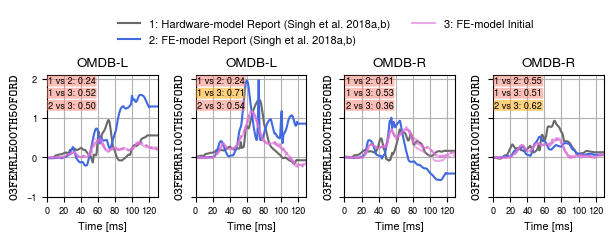

In [19]:
def plot_femur():
    s = "03"
    plots = [
        f"{s}FEMRLE00??50FORD$OMDB-L",
        f"{s}FEMRRI00??50FORD$OMDB-L",
        f"{s}FEMRLE00??50FORD$OMDB-R",
        f"{s}FEMRRI00??50FORD$OMDB-R",
    ]
    plots = [["none"] * 4, plots]
    db_cae = get_new_cae(model="000_Base_Model")

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=True,
        layout="constrained",
        height_ratios=[0.01, 1],
    )

    for field in sum(plots, []):
        if field != "none":
            ch, case = field.split("$")
            # plot report data
            report = DB_REPORT[DB_REPORT["Channel"].eq(ch) & DB_REPORT["Case"].eq(case)]
            report_ch = {}
            flip = 1
            for i, ass in enumerate(REPORT_ASS):
                report2 = report[report["Source"].eq(ass)]
                if report2.shape[0]:
                    report_ch[ass] = UNIFIER.unify(db=report2[["Time", "Value"]].set_index("Time").dropna() * flip)["Value"]
                    ax[field].plot(report_ch[ass].index, report_ch[ass], label=ass, c=CS_REPORT[i])

            if REPORT_ASS[0] in report_ch and REPORT_ASS[1] in report_ch:
                iso_report = rating_iso_18571_short(
                    signal_ref=report_ch[REPORT_ASS[0]].loc[20:120].values,
                    signal_comp=report_ch[REPORT_ASS[1]].loc[20:120].values,
                )
            else:
                iso_report = None

            # plot CAE data
            cae = db_cae[db_cae["Channel"].eq(ch) & db_cae["Case"].eq(case)]

            # plot single curves
            isos = defaultdict(list)
            for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")
                test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                ax[field].plot(
                    test.index, test, c=NEW_CAES[0], ls=LSS[j], label="3: FE-model Initial" if j == 0 else "", alpha=0.6
                )

                for ass in report_ch.keys():
                    isos[ass].append(
                        rating_iso_18571_short(signal_ref=report_ch[ass].loc[20:120].values, signal_comp=test.loc[20:120].values)
                    )

            if iso_report is not None:
                add_textbox(
                    ax=ax[field],
                    j=0,
                    f1=REPORT_ASS[0][0],
                    f2=REPORT_ASS[1][0],
                    iso=iso_report,
                )
            for j, ass in enumerate(isos.keys(), 1):
                if isos[ass]:
                    add_textbox(
                        ax=ax[field],
                        j=j,
                        f1=ass[0],
                        f2="3",
                        iso=np.median(isos[ass]),
                    )

            # format
            ax[field].set_title(case)
            ax[field].set_xlabel("Time [ms]")
            ax[field].grid()
            ax[field].set_xlim([0, 130])
            ax[field].set_yticks(np.arange(-1, 3, 1))
            ax[field].set_ylabel(
                ch.replace("??", "TH"), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"}
            )

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03FEMRLE00??50FORD$OMDB-L"].get_legend_handles_labels(), loc="upper center", ncol=2)

    fig.set_figwidth(WIDTH)
    fig.set_figheight(2.3)
    fig.savefig(FIG_DIR / "base_model_femur_force.pdf")


plot_femur()

In [ ]:
def plot_boundary_cae_comp(cae_ref: str, cae_comp: str):
    channels = ["00COG00000VH00VEXD", "00COG00000VH00VEYD", "00COG00000VH00ACXD", "00COG00000VH00ACYD", "03BELTB300VH00FORD"]
    units = ["X-Velocity [m/s]", "Y-Velocity [m/s]", "X-Acceleration [g]", "Y Acceleration [g]", "B3-Force [kN]"]
    cases = ["Full Frontal", "Moderate Overlap Left", "Moderate Overlap Right"]

    plots = [[f"{channel}${case}" for case in cases] for channel in channels]
    plots = [["none"] * len(cases), *plots]

    y_ranges = {1: [-5, 30], 2: [-5, 30], 3: [-50, 30], 4: [-50, 30], 5: [0, 5.5]}

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        figsize=(WIDTH, 1.5 * len(channels)),
        sharex=True,
        sharey=False,
        layout="constrained",
        height_ratios=[0.01, *([1] * len(channels))],
    )

    for col, case in enumerate(cases):
        for row, channel in enumerate(channels):
            field = f"{channel}${case}"

            data = defaultdict(dict)
            for i, cae_name in enumerate(db_caes.keys()):
                flip = -1 if channel.startswith("00COG") and cae_name == cae_comp else 1
                db_cae = db_caes[cae_name]

                # cae data
                cae = db_cae[
                    db_cae["Channel"].eq(channel) & db_cae["Case"].eq(case) & (db_cae["Side"].eq("PA") | db_cae["Side"].isna())
                ]

                for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                    # plot single curves
                    cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")
                    test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"] * flip

                    ax[field].plot(
                        test.index,
                        test,
                        c=NEW_CAES[i],
                        ls=LSS[j],
                        label=" ".join(cae_name.split("_")[1:]) if j == 0 else "",
                        alpha=0.6,
                    )
                    data[cae_name][setting] = test

            # isos
            isos = []
            for setting in data[cae_ref].keys():
                isos.append(
                    rating_iso_18571_short(
                        signal_ref=data[cae_ref][setting].loc[20:120].values,
                        signal_comp=data[cae_comp][setting].loc[20:120].values,
                    )
                )

            add_textbox(
                ax=ax[field],
                j=0,
                f1="ISO 18571",
                f2="Median",
                iso=np.median(isos),
            )

            # format
            if row == 0:
                ax[field].set_title(case)
            if col == 0:
                ax[field].annotate(units[row], (-0.25, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")
            ax[field].set_ylim(y_ranges[row + 1])
            if col != 0:
                ax[field].set_yticklabels([])
            if row == 4:
                ax[field].set_xlabel("Time [ms]")
            # if "VE" in channel:
            #    ax[field].set_yticks(np.arange(-15, 16, 5))
            ax[field].grid()
            ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["00COG00000VH00ACYD$Full Frontal"].get_legend_handles_labels(), loc="upper center", ncol=3)

    fig.savefig(FIG_DIR / f"{cae_ref}_vs_{cae_comp}_pulse_b3.pdf")


plot_boundary_cae_comp(cae_ref="000_Base_Model", cae_comp="100_Guided_BIW")

2025-01-03 21:28:02,743     INFO  MainProcess  MainThread maxp pruned
2025-01-03 21:28:02,746     INFO  MainProcess  MainThread cmap pruned
2025-01-03 21:28:02,747     INFO  MainProcess  MainThread post pruned
2025-01-03 21:28:02,748     INFO  MainProcess  MainThread FFTM dropped
2025-01-03 21:28:02,751     INFO  MainProcess  MainThread GPOS pruned
2025-01-03 21:28:02,752     INFO  MainProcess  MainThread GSUB pruned
2025-01-03 21:28:02,755     INFO  MainProcess  MainThread glyf pruned
2025-01-03 21:28:02,756     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-03 21:28:02,757     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-03 21:28:02,758     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 15 glyphs before
2025-01-03 21:28:02,759     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'G', 'H', 'O', 'V', 'X', 'Y', 'glyph1', 'space', 'uni000D', 'zero']
2025-01-03 21:28:02,760     INFO  MainProcess  MainThread Gl

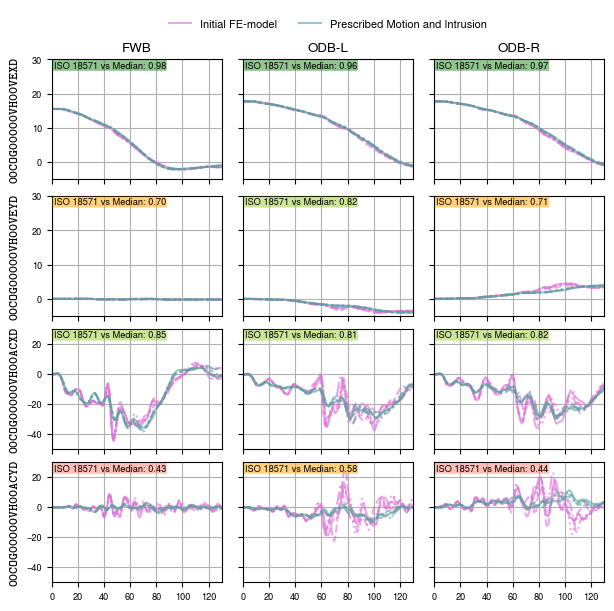

In [15]:
def plot_boundary_cae_comp_no_b3(cae_ref: str, cae_comp: str):
    channels = ["00COG00000VH00VEXD", "00COG00000VH00VEYD", "00COG00000VH00ACXD", "00COG00000VH00ACYD"]
    cases = ["FWB", "ODB-L", "ODB-R"]
    case_renamer = {"000_Base_Model":"Initial FE-model", "100_Guided_BIW":"Prescribed Motion and Intrusion"}

    plots = [[f"{channel}${case}" for case in cases] for channel in channels]
    plots = [["none"] * len(cases), *plots]

    y_ranges = {1: [-5, 30], 2: [-5, 30], 3: [-50, 30], 4: [-50, 30], 5: [0, 5.5]}

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=False,
        layout="constrained",
        height_ratios=[0.01, *([1] * len(channels))],
    )

    for col, case in enumerate(cases):
        for row, channel in enumerate(channels):
            field = f"{channel}${case}"

            data = defaultdict(dict)
            for i, cae_name in enumerate(db_caes.keys()):
                flip = -1 if channel.startswith("00COG") and cae_name == cae_comp else 1
                db_cae = db_caes[cae_name]

                # cae data
                cae = db_cae[
                    db_cae["Channel"].eq(channel) & db_cae["Case"].eq(case) & (db_cae["Side"].eq("PA") | db_cae["Side"].isna())
                ]

                for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                    # plot single curves
                    cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")
                    test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"] * flip

                    ax[field].plot(
                        test.index,
                        test,
                        c=NEW_CAES[i],
                        ls=LSS[j],
                        label=case_renamer[cae_name] if j == 0 else "",
                        alpha=0.6,
                    )
                    data[cae_name][setting] = test

            # isos
            isos = []
            for setting in data[cae_ref].keys():
                isos.append(
                    rating_iso_18571_short(
                        signal_ref=data[cae_ref][setting].loc[20:120].values,
                        signal_comp=data[cae_comp][setting].loc[20:120].values,
                    )
                )

            add_textbox(
                ax=ax[field],
                j=0,
                f1="ISO 18571",
                f2="Median",
                iso=np.median(isos),
            )

            # format
            if row == 0:
                ax[field].set_title(case)
            if col == 0:
                ax[field].set_ylabel(channel, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
            ax[field].set_ylim(y_ranges[row + 1])
            if col != 0:
                ax[field].set_yticklabels([])
            if row == 4:
                ax[field].set_xlabel("Time [ms]")
            # if "VE" in channel:
            #    ax[field].set_yticks(np.arange(-15, 16, 5))
            ax[field].grid()
            ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["00COG00000VH00ACYD$FWB"].get_legend_handles_labels(), loc="upper center", ncol=3)

    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.5 * len(channels))
    fig.align_ylabels(list(ax.values()))
    fig.savefig(FIG_DIR / f"{cae_ref}_vs_{cae_comp}_pulse.pdf")


plot_boundary_cae_comp_no_b3(cae_ref="000_Base_Model", cae_comp="100_Guided_BIW")

2025-01-04 01:12:53,496     INFO  MainProcess  MainThread maxp pruned
2025-01-04 01:12:53,500     INFO  MainProcess  MainThread cmap pruned
2025-01-04 01:12:53,502     INFO  MainProcess  MainThread post pruned
2025-01-04 01:12:53,503     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 01:12:53,505     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 01:12:53,506     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 01:12:53,509     INFO  MainProcess  MainThread glyf pruned
2025-01-04 01:12:53,510     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 01:12:53,513     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 01:12:53,514     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 22 glyphs before
2025-01-04 01:12:53,514     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'L', 'O', 'P', 'R', 'S', 'T', 'V', 'X', 'Y', 'five', 'glyph1', 'question', 'space', 'three', 'uni000D', 'zero']
2025-01-04 

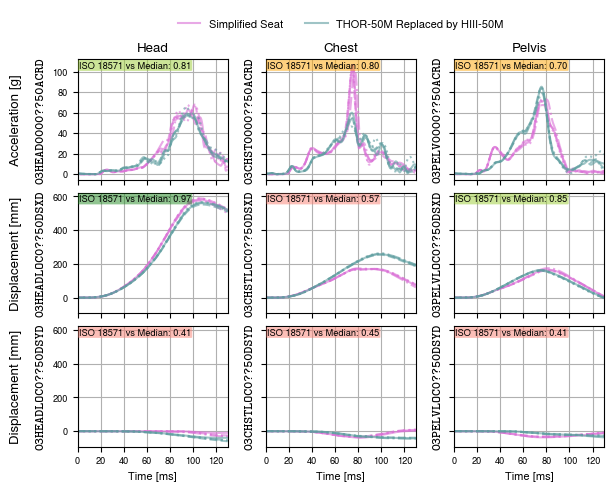

In [65]:
def plot_occupant_cases(
    case: str, cae_ref: str, cae_comp: str, alt_name_cae_ref: str, alt_name_cae_comp: str, close: bool = False, occu:str="??"
):
    s = "03"
    parts = ["HEAD", "CHST", "PELV"]
    parts_dict = {"HEAD": "Head", "CHST": "Chest", "PELV": "Pelvis"}
    plots = [
        [f"{s}{part}0000??50ACRD" for part in parts],
        [f"{s}{part}LOC0??50DSXD" for part in parts],
        [f"{s}{part}LOC0??50DSYD" for part in parts],
    ]

    plots = [["none"] * 3, *plots]

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        # sharey=True,
        layout="constrained",
        height_ratios=[0.01, *([1] * 3)],
    )
    # share y
    [ax[col].sharey(ax[plots[1][i + 1]]) for i, col in enumerate(plots[1][:-1])]
    [ax[field].sharey(ax[sum(plots[2:], [])[i + 1]]) for i, field in enumerate(sum(plots[2:], [])[:-1])]
    [
        ax[row[i + 1]].yaxis.set_tick_params(which="both", labelleft=False, labelright=False)
        for row in plots[1:]
        for i, _ in enumerate(row[:-1])
    ]

    for field in sum(plots, []):
        if field != "none":
            data = defaultdict(dict)
            for i, cae_name in enumerate(db_caes.keys()):
                db_cae = db_caes[cae_name]
                # plot CAE data
                cae = db_cae[db_cae["Channel"].eq(field) & db_cae["Case"].eq(case)]
                isos = defaultdict(list)
                for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                    cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

                    test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                    ax[field].plot(
                        test.index,
                        test,
                        c=NEW_CAES[i],
                        ls=LSS[j],
                        label=(alt_name_cae_comp if cae_name == cae_comp else alt_name_cae_ref) if j == 0 else "",
                        alpha=0.6,
                    )

                    data[cae_name][setting] = test

            # isos
            isos = []
            for setting in data[cae_ref].keys():
                if setting in data[cae_comp] and setting in data[cae_ref]:
                    isos.append(
                        rating_iso_18571_short(
                            signal_ref=data[cae_ref][setting].loc[20:120].values,
                            signal_comp=data[cae_comp][setting].loc[20:120].values,
                        )
                    )

            add_textbox(
                ax=ax[field],
                j=0,
                f1="ISO 18571",
                f2="Median",
                iso=np.median(isos),
            )

        # format
        ax[field].set_ylabel(field.replace("??", occu), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        if field.endswith("ACRD"):
            ax[field].set_title(parts_dict[field[2:6]])
        if "HEAD" in field:
            ax[field].annotate(
                "Acceleration [g]" if field[-4:-2] =="AC" else "Displacement [mm]",
                (-0.45, 0.5),
                rotation=90,
                va="center",
                xycoords="axes fraction",
                fontsize="large",
            )
        if field.endswith("DSYD"):
            ax[field].set_xlabel("Time [ms]")
        ax[field].grid()
        ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03HEAD0000??50ACRD"].get_legend_handles_labels(), loc="upper center", ncol=3)

    f_path = FIG_DIR / f"{cae_ref}_vs_{cae_comp}__{case.replace(' ', '_')}_occupant.pdf"
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.6 * 3)
    fig.savefig(f_path)
    LOG.warning("Saved to %s", f_path)
    if close:
        plt.close(fig)


plot_occupant_cases(
    case="FWB",
    cae_ref="300_Seat_Simplified",
    cae_comp="400_HIII",
    alt_name_cae_ref="Simplified Seat",
    alt_name_cae_comp="THOR-50M Replaced by HIII-50M",
)

2025-01-04 01:13:41,604     INFO  MainProcess  MainThread maxp pruned
2025-01-04 01:13:41,607     INFO  MainProcess  MainThread cmap pruned
2025-01-04 01:13:41,608     INFO  MainProcess  MainThread post pruned
2025-01-04 01:13:41,609     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 01:13:41,611     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 01:13:41,613     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 01:13:41,615     INFO  MainProcess  MainThread glyf pruned
2025-01-04 01:13:41,616     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 01:13:41,617     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 01:13:41,618     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 21 glyphs before
2025-01-04 01:13:41,619     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'L', 'O', 'P', 'R', 'S', 'T', 'V', 'X', 'Y', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-04 01:13:41,620

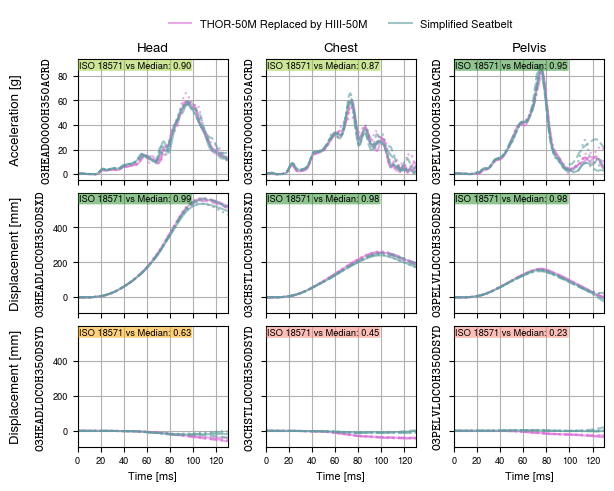

In [66]:
plot_occupant_cases(
    case="FWB",
    cae_ref="400_HIII",
    cae_comp="700_Simplified_Belt",
    alt_name_cae_ref="THOR-50M Replaced by HIII-50M",
    alt_name_cae_comp="Simplified Seatbelt",
    occu="H3",
)

In [ ]:
PAIRS = [
    (("000_Base_Model", "Full Crash"), "100_Guided_BIW"),
    (("100_Guided_BIW", "Original PAB"), "200_PAB_Simplified"),
    (("200_PAB_Simplified", "Original Seat"), "300_Seat_Simplified"),
    (("300_Seat_Simplified", "THOR"), "400_HIII"),
    (("400_HIII", "With CAB"), "500_NoCAB"),
    (("200_PAB_Simplified", "THOR (Original Seat)"), "400_HIII"),
    (("500_NoCAB", "With Door"), "600_NoDoor"),
    (("600_NoDoor", "Original Belt"), "700_Simplified_Belt"),
    (("400_HIII", "Original Belt"), "700_Simplified_Belt"),
    (("700_Simplified_Belt", "Fine Meshed BIW"), "800_Simplified_BIW"),
    (("800_Simplified_BIW", "With Intrusion"), "900_NoIntrusion"),
    (("900_NoIntrusion", "Original Dashboard"), "950_Dash_Rigid"),
    (("950_Dash_Rigid", "Original Carpet"), "990_Carpet_Rigid"),
]
_ = [
    plot_occupant_cases(case=cs, cae_ref=c1, alt_name_cae_ref=alt, cae_comp=c2, alt_name_cae_comp=c2,close=True)
    for cs in ("Full Frontal", "Moderate Overlap Left", "Moderate Overlap Right")
    for (c1, alt), c2 in PAIRS
]

2025-01-03 23:46:19,667     INFO  MainProcess  MainThread maxp pruned
2025-01-03 23:46:19,673     INFO  MainProcess  MainThread cmap pruned
2025-01-03 23:46:19,674     INFO  MainProcess  MainThread post pruned
2025-01-03 23:46:19,676     INFO  MainProcess  MainThread FFTM dropped
2025-01-03 23:46:19,678     INFO  MainProcess  MainThread GPOS pruned
2025-01-03 23:46:19,679     INFO  MainProcess  MainThread GSUB pruned
2025-01-03 23:46:19,682     INFO  MainProcess  MainThread glyf pruned
2025-01-03 23:46:19,683     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-03 23:46:19,684     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-03 23:46:19,685     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 19 glyphs before
2025-01-03 23:46:19,685     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'B', 'D', 'E', 'F', 'H', 'L', 'O', 'P', 'R', 'T', 'V', 'glyph1', 'six', 'space', 'three', 'uni000D', 'zero']
2025-01-03 23:46:19,687     INFO  

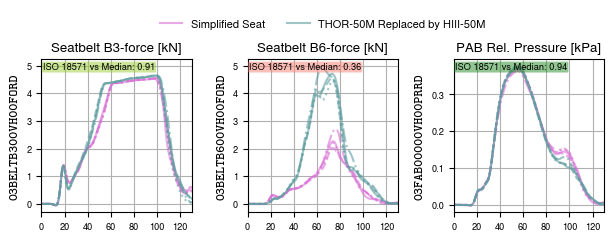

In [41]:
def plot_rhs_cases(case: str, cae_ref: str, cae_comp: str, alt_name_cae_ref: str, alt_name_cae_comp: str, close: bool = False):
    plots = [["03BELTB300VH00FORD", "03BELTB600VH00FORD", "03FAB00000VH00PRRD"]]

    plots = [["none"] * 3, *plots]

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        # sharey=True,
        layout="constrained",
        height_ratios=[0.01, 1],
    )
    ax[plots[1][0]].sharey(ax[plots[1][1]])

    for field in sum(plots, []):
        t_start = 50 if field == plots[1][-1] else 20
        if field != "none":
            data = defaultdict(dict)
            for i, cae_name in enumerate(db_caes.keys()):
                db_cae = db_caes[cae_name]
                # plot CAE data
                cae = db_cae[db_cae["Channel"].eq(field) & db_cae["Case"].eq(case)]
                isos = defaultdict(list)
                for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                    cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

                    test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                    ax[field].plot(
                        test.index,
                        test,
                        c=NEW_CAES[i],
                        ls=LSS[j],
                        label=(alt_name_cae_comp if cae_name == cae_comp else alt_name_cae_ref) if j == 0 else "",
                        alpha=0.6,
                    )

                    data[cae_name][setting] = test

            # isos
            isos = []
            for setting in data[cae_ref].keys():
                if setting in data[cae_comp] and setting in data[cae_ref]:
                    isos.append(
                        rating_iso_18571_short(
                            signal_ref=data[cae_ref][setting].loc[t_start:120].values,
                            signal_comp=data[cae_comp][setting].loc[t_start:120].values,
                        )
                    )

            add_textbox(
                ax=ax[field],
                j=0,
                f1="ISO 18571",
                f2="Median",
                iso=np.median(isos),
            )

        # format
        if field != "none":
            ax[field].set_title(f"Seatbelt {field[6:8]}-force [kN]" if "BELT" in field else "PAB Rel. Pressure [kPa]")
            ax[field].set_ylabel(field, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        if field.endswith("DSYD"):
            ax[field].set_xlabel("Time [ms]")
        ax[field].grid()
        ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03BELTB300VH00FORD"].get_legend_handles_labels(), loc="upper center", ncol=3)

    f_path = FIG_DIR / f"{cae_ref}_vs_{cae_comp}__{case.replace(' ', '_')}_rhs.pdf"
    fig.set_figwidth(WIDTH)
    fig.set_figheight(2.3)
    fig.savefig(f_path)
    LOG.warning("Saved to %s", f_path)
    if close:
        plt.close(fig)


# plot_rhs_cases(case="Full Frontal", cae_ref="000_Base_Model", cae_comp="100_Guided_BIW", alt_name="Full Crash")
plot_rhs_cases(case="FWB", cae_ref="300_Seat_Simplified", cae_comp="400_HIII", alt_name_cae_ref="Simplified Seat", alt_name_cae_comp="THOR-50M Replaced by HIII-50M")

2025-01-03 22:03:10,096     INFO  MainProcess  MainThread maxp pruned
2025-01-03 22:03:10,100     INFO  MainProcess  MainThread cmap pruned
2025-01-03 22:03:10,101     INFO  MainProcess  MainThread post pruned
2025-01-03 22:03:10,102     INFO  MainProcess  MainThread FFTM dropped
2025-01-03 22:03:10,107     INFO  MainProcess  MainThread GPOS pruned
2025-01-03 22:03:10,108     INFO  MainProcess  MainThread GSUB pruned
2025-01-03 22:03:10,114     INFO  MainProcess  MainThread glyf pruned
2025-01-03 22:03:10,115     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-03 22:03:10,116     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-03 22:03:10,117     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 14 glyphs before
2025-01-03 22:03:10,120     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'B', 'D', 'F', 'H', 'P', 'R', 'V', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-03 22:03:10,122     INFO  MainProcess  MainThread Gly

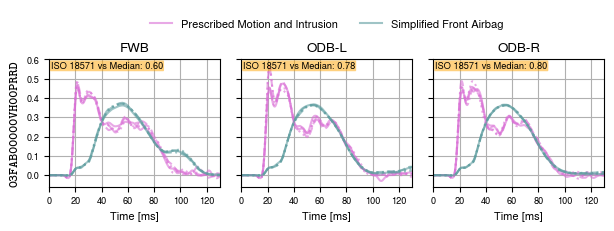

In [24]:
def plot_airbag_cases(cae_ref: str, cae_comp: str, cae_ref_alt_name: str, cae_comp_alt_name, close: bool = False):
    plots = [[f"03FAB00000VH00PRRD${lc}" for lc in ("FWB", "ODB-L", "ODB-R")]]

    plots = [["none"] * 3, *plots]

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=True,
        layout="constrained",
        height_ratios=[0.01, 1],
    )

    for field in sum(plots, []):
        if field != "none":
            ch, case = field.split("$")
            if field != "none":
                data = defaultdict(dict)
                for i, cae_name in enumerate(db_caes.keys()):
                    db_cae = db_caes[cae_name]
                    # plot CAE data
                    cae = db_cae[db_cae["Channel"].eq(ch) & db_cae["Case"].eq(case)]
                    isos = defaultdict(list)
                    for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                        cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

                        test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                        ax[field].plot(
                            test.index,
                            test,
                            c=NEW_CAES[i],
                            ls=LSS[j],
                            label=(cae_comp_alt_name if cae_name == cae_comp else cae_ref_alt_name) if j == 0 else "",
                            alpha=0.6,
                        )

                        data[cae_name][setting] = test

                # isos
                isos = []
                for setting in data[cae_ref].keys():
                    if setting in data[cae_comp] and setting in data[cae_ref]:
                        isos.append(
                            rating_iso_18571_short(
                                signal_ref=data[cae_ref][setting].loc[50:120].values,
                                signal_comp=data[cae_comp][setting].loc[50:120].values,
                            )
                        )

                add_textbox(
                    ax=ax[field],
                    j=0,
                    f1="ISO 18571",
                    f2="Median",
                    iso=np.median(isos),
                )

            ax[field].set_title(case)
            ax[field].set_xlabel("Time [ms]")
            ax[field].set_yticks(np.arange(0, 0.7, 0.1))

        if field == plots[1][0]:
            ax[field].set_ylabel(
                "03FAB00000VH00PRRD", {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"}
            )

        ax[field].grid()
        ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03FAB00000VH00PRRD$FWB"].get_legend_handles_labels(), loc="upper center", ncol=3)

    f_path = FIG_DIR / f"{cae_ref}_vs_{cae_comp}__pab_pressur.pdf"

    fig.set_figwidth(WIDTH)
    fig.set_figheight(2.2)
    fig.savefig(f_path)
    LOG.warning("Saved to %s", f_path)
    if close:
        plt.close(fig)


plot_airbag_cases(
    cae_ref="100_Guided_BIW",
    cae_comp="200_PAB_Simplified",
    cae_ref_alt_name="Prescribed Motion and Intrusion",
    cae_comp_alt_name="Simplified Front Airbag",
)

2025-01-04 00:58:09,057     INFO  MainProcess  MainThread maxp pruned
2025-01-04 00:58:09,060     INFO  MainProcess  MainThread cmap pruned
2025-01-04 00:58:09,061     INFO  MainProcess  MainThread post pruned
2025-01-04 00:58:09,061     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 00:58:09,063     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 00:58:09,064     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 00:58:09,067     INFO  MainProcess  MainThread glyf pruned
2025-01-04 00:58:09,068     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 00:58:09,069     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 00:58:09,070     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2025-01-04 00:58:09,072     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'L', 'P', 'S', 'T', 'V', 'X', 'Y', 'Z', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-04 00:58:09,075     

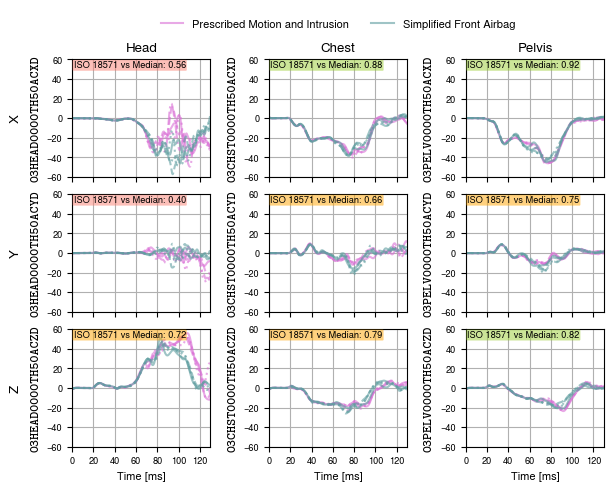

In [61]:
def plot_occupant_cases_only_acc(
    case: str, cae_ref: str, cae_comp: str, alt_name_cae_ref: str, alt_name_cae_comp: str, close: bool = False, occu: str = "TH"
):
    s = "03"
    parts = ["HEAD", "CHST", "PELV"]
    plots = [
        [f"{s}{part}0000??50ACXD" for part in parts],
        [f"{s}{part}0000??50ACYD" for part in parts],
        [f"{s}{part}0000??50ACZD" for part in parts],
    ]
    part_dict = {"HEAD": "Head", "CHST": "Chest", "PELV": "Pelvis"}

    plots = [["none"] * 3, *plots]

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        # sharey=True,
        layout="constrained",
        height_ratios=[0.01, *([1] * 3)],
    )

    for field in sum(plots, []):
        if field != "none":
            data = defaultdict(dict)
            for i, cae_name in enumerate(db_caes.keys()):
                db_cae = db_caes[cae_name]
                # plot CAE data
                cae = db_cae[db_cae["Channel"].eq(field) & db_cae["Case"].eq(case)]
                isos = defaultdict(list)
                for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                    cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

                    test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                    ax[field].plot(
                        test.index,
                        test,
                        c=NEW_CAES[i],
                        ls=LSS[j],
                        label=(alt_name_cae_comp if cae_name == cae_comp else alt_name_cae_ref) if j == 0 else "",
                        alpha=0.6,
                    )

                    data[cae_name][setting] = test

            # isos
            isos = []
            for setting in data[cae_ref].keys():
                if setting in data[cae_comp] and setting in data[cae_ref]:
                    isos.append(
                        rating_iso_18571_short(
                            signal_ref=data[cae_ref][setting].loc[20:120].values,
                            signal_comp=data[cae_comp][setting].loc[20:120].values,
                        )
                    )

            add_textbox(
                ax=ax[field],
                j=0,
                f1="ISO 18571",
                f2="Median",
                iso=np.median(isos),
            )

        # format
        if field.endswith("ACXD"):
            ax[field].set_title(part_dict[field[2:6]])
        if "HEAD" in field:
            ax[field].annotate(
                field[-2],
                (-0.45, 0.5),
                rotation=90,
                va="center",
                xycoords="axes fraction",
                fontsize="large",
            )
        ax[field].set_ylabel(
            field.replace("??", occu), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"}
        )
        ax[field].set_ylim([-60, 60])
        if field.endswith("ACZD"):
            ax[field].set_xlabel("Time [ms]")
        ax[field].grid()
        ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03HEAD0000??50ACXD"].get_legend_handles_labels(), loc="upper center", ncol=3)

    f_path = FIG_DIR / f"{cae_ref}_vs_{cae_comp}__{case.replace(' ', '_')}_occupant_only_acc.pdf"
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.6 * 3)
    fig.savefig(f_path)
    LOG.warning("Saved to %s", f_path)
    if close:
        plt.close(fig)


plot_occupant_cases_only_acc(
    case="FWB",
    cae_ref="100_Guided_BIW",
    cae_comp="200_PAB_Simplified",
    alt_name_cae_ref="Prescribed Motion and Intrusion",
    alt_name_cae_comp="Simplified Front Airbag",
)

2025-01-03 22:59:44,419     INFO  MainProcess  MainThread maxp pruned
2025-01-03 22:59:44,422     INFO  MainProcess  MainThread cmap pruned
2025-01-03 22:59:44,423     INFO  MainProcess  MainThread post pruned
2025-01-03 22:59:44,424     INFO  MainProcess  MainThread FFTM dropped
2025-01-03 22:59:44,427     INFO  MainProcess  MainThread GPOS pruned
2025-01-03 22:59:44,428     INFO  MainProcess  MainThread GSUB pruned
2025-01-03 22:59:44,431     INFO  MainProcess  MainThread glyf pruned
2025-01-03 22:59:44,431     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-03 22:59:44,432     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-03 22:59:44,433     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2025-01-03 22:59:44,433     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'B', 'D', 'E', 'F', 'H', 'L', 'O', 'R', 'S', 'T', 'U', 'V', 'five', 'four', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-03 22:59:44,434  

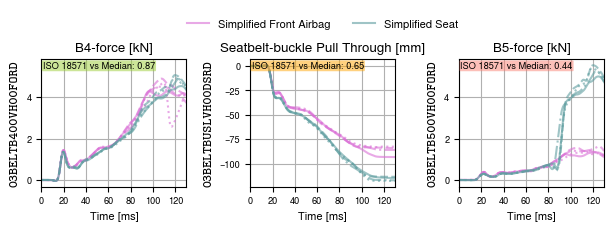

In [33]:
def plot_around_belt_buckle(case: str, cae_ref: str, cae_comp: str, alt_name_cae_ref: str,alt_name_cae_comp: str, close: bool = False):
    plots = [["03BELTB400VH00FORD", "03BELTBUSLVH00DSRD", "03BELTB500VH00FORD"]]

    plots = [["none"] * 3, *plots]

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        layout="constrained",
        height_ratios=[0.01, 1],
    )

    ax[plots[1][0]].sharey(ax[plots[1][-1]])

    for field in sum(plots, []):
        if field != "none":
            ch = field
            if field != "none":
                data = defaultdict(dict)
                for i, cae_name in enumerate(db_caes.keys()):
                    db_cae = db_caes[cae_name]
                    # plot CAE data
                    cae = db_cae[db_cae["Channel"].eq(ch) & db_cae["Case"].eq(case)]
                    isos = defaultdict(list)
                    for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                        cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

                        test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                        ax[field].plot(
                            test.index,
                            test,
                            c=NEW_CAES[i],
                            ls=LSS[j],
                            label=(alt_name_cae_comp if cae_name == cae_comp else alt_name_cae_ref) if j == 0 else "",
                            alpha=0.6,
                        )

                        data[cae_name][setting] = test

                # isos
                isos = []
                for setting in data[cae_ref].keys():
                    if setting in data[cae_comp] and setting in data[cae_ref]:
                        isos.append(
                            rating_iso_18571_short(
                                signal_ref=data[cae_ref][setting].loc[20:120].values,
                                signal_comp=data[cae_comp][setting].loc[20:120].values,
                            )
                        )

                add_textbox(
                    ax=ax[field],
                    j=0,
                    f1="ISO 18571",
                    f2="Median",
                    iso=np.median(isos),
                )

            ax[field].set_xlabel("Time [ms]")
            ax[field].set_ylabel(field, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})

            if field.endswith("FORD"):
                #ax[field].set_ylabel("Force [kN]")
                ax[field].set_title(f"{field[6:8]}-force [kN]")
            else:
                #ax[field].set_ylabel("Pull Through [mm]")
                ax[field].set_title("Seatbelt-buckle Pull Through [mm]")

        ax[field].grid()
        ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03BELTB400VH00FORD"].get_legend_handles_labels(), loc="upper center", ncol=3)

    f_path = FIG_DIR / f"{cae_ref}_vs_{cae_comp}_{case}_around_belt_buckle.pdf"
    fig.set_figwidth(WIDTH)
    fig.set_figheight(2.2)
    fig.savefig(f_path)
    LOG.warning("Saved to %s", f_path)
    if close:
        plt.close(fig)


plot_around_belt_buckle(
    case="ODB-L", cae_ref="200_PAB_Simplified", cae_comp="300_Seat_Simplified", alt_name_cae_ref="Simplified Front Airbag", alt_name_cae_comp="Simplified Seat"
)

2025-01-04 00:52:12,320     INFO  MainProcess  MainThread maxp pruned
2025-01-04 00:52:12,323     INFO  MainProcess  MainThread cmap pruned
2025-01-04 00:52:12,324     INFO  MainProcess  MainThread post pruned
2025-01-04 00:52:12,325     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 00:52:12,329     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 00:52:12,330     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 00:52:12,334     INFO  MainProcess  MainThread glyf pruned
2025-01-04 00:52:12,335     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 00:52:12,335     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 00:52:12,336     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2025-01-04 00:52:12,337     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'L', 'P', 'S', 'T', 'V', 'X', 'Y', 'Z', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-04 00:52:12,338     

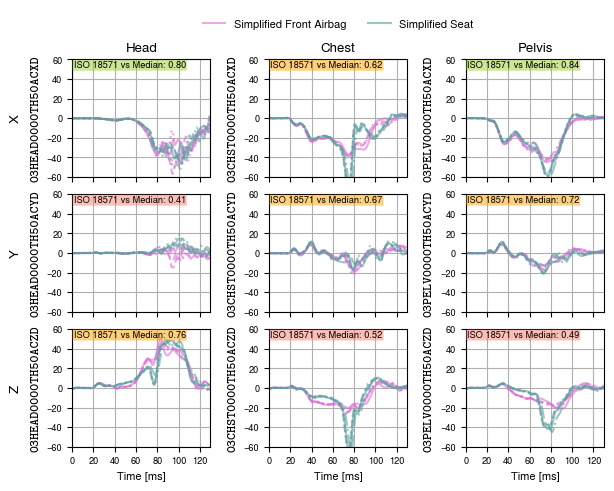

In [59]:
plot_occupant_cases_only_acc(
    case="FWB",
    cae_ref="200_PAB_Simplified",
    cae_comp="300_Seat_Simplified",
    alt_name_cae_ref="Simplified Front Airbag",
    alt_name_cae_comp="Simplified Seat",
)

2025-01-04 01:22:32,569     INFO  MainProcess  MainThread maxp pruned
2025-01-04 01:22:32,572     INFO  MainProcess  MainThread cmap pruned
2025-01-04 01:22:32,574     INFO  MainProcess  MainThread post pruned
2025-01-04 01:22:32,575     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 01:22:32,577     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 01:22:32,578     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 01:22:32,583     INFO  MainProcess  MainThread glyf pruned
2025-01-04 01:22:32,585     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 01:22:32,585     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 01:22:32,586     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 16 glyphs before
2025-01-04 01:22:32,587     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'D', 'E', 'F', 'I', 'L', 'M', 'O', 'R', 'five', 'glyph1', 'question', 'space', 'three', 'uni000D', 'zero']
2025-01-04 01:22:32,588     INFO  MainPro

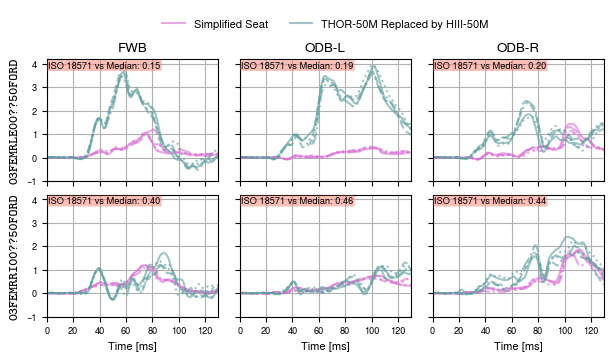

In [68]:
def plot_femur_only(cae_ref: str, cae_comp: str, alt_name_cae_ref: str,alt_name_cae_comp: str, close: bool = False, yticks=None, occu="??"):
    plots = [
        [f"03FEMRLE00??50FORD${lc}" for lc in ("FWB", "ODB-L", "ODB-R")],
        [f"03FEMRRI00??50FORD${lc}" for lc in ("FWB", "ODB-L", "ODB-R")],
    ]

    plots = [["none"] * 3, *plots]

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}
        
    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=True,
        layout="constrained",
        height_ratios=[0.01, 1, 1],
    )

    for field in sum(plots, []):
        if field != "none":
            ch, case = field.split("$")

            data = defaultdict(dict)
            for i, cae_name in enumerate(db_caes.keys()):
                db_cae = db_caes[cae_name]
                flip = -1 if int(cae_name.split("_")[0]) > 300 else 1
                # plot CAE data
                cae = db_cae[db_cae["Channel"].eq(ch) & db_cae["Case"].eq(case)]
                isos = defaultdict(list)
                for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                    cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

                    test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"] * flip

                    ax[field].plot(
                        test.index,
                        test,
                        c=NEW_CAES[i],
                        ls=LSS[j],
                        label=(alt_name_cae_comp if cae_name == cae_comp else alt_name_cae_ref) if j == 0 else "",
                        alpha=0.6,
                    )

                    data[cae_name][setting] = test

            # isos
            isos = []
            for setting in data[cae_ref].keys():
                if setting in data[cae_comp] and setting in data[cae_ref]:
                    isos.append(
                        rating_iso_18571_short(
                            signal_ref=data[cae_ref][setting].loc[20:120].values,
                            signal_comp=data[cae_comp][setting].loc[20:120].values,
                        )
                    )

            add_textbox(
                ax=ax[field],
                j=0,
                f1="ISO 18571",
                f2="Median",
                iso=np.median(isos),
            )

            if field in plots[1]:
                ax[field].set_title(case)
            if field in plots[2]:
                ax[field].set_xlabel("Time [ms]")
            if field == plots[1][0] or field == plots[2][0]:
                ax[field].set_ylabel(ch.replace("??", occu), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
            if yticks is not None:
                ax[field].set_yticks(yticks)

            ax[field].grid()
            ax[field].set_xlim([0, 130])
        # ax[field].set_yticks(np.arange(0,3.6,0.5))

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03FEMRLE00??50FORD$FWB"].get_legend_handles_labels(), loc="upper center", ncol=3)

    f_path = FIG_DIR / f"{cae_ref}_vs_{cae_comp}_femur_only.pdf"
    fig.set_figwidth(WIDTH)
    fig.set_figheight(3.5)
    fig.savefig(f_path)
    LOG.warning("Saved to %s", f_path)
    if close:
        plt.close(fig)


plot_femur_only(cae_ref="300_Seat_Simplified", cae_comp="400_HIII", alt_name_cae_ref="Simplified Seat", alt_name_cae_comp="THOR-50M Replaced by HIII-50M", yticks=np.arange(-1,4.1,1))

In [ ]:
sorted(get_new_cae()["Channel"].unique())

In [ ]:
plot_occupant_cases(
    case="Moderate Overlap Right", cae_ref="400_HIII", alt_name="With Door & CAB", cae_comp="600_NoDoor", close=False
)

2025-01-04 00:58:48,450     INFO  MainProcess  MainThread maxp pruned
2025-01-04 00:58:48,454     INFO  MainProcess  MainThread cmap pruned
2025-01-04 00:58:48,455     INFO  MainProcess  MainThread post pruned
2025-01-04 00:58:48,456     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 00:58:48,459     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 00:58:48,460     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 00:58:48,463     INFO  MainProcess  MainThread glyf pruned
2025-01-04 00:58:48,464     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 00:58:48,465     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 00:58:48,466     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2025-01-04 00:58:48,467     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'L', 'P', 'S', 'T', 'V', 'X', 'Y', 'Z', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-04 00:58:48,469     

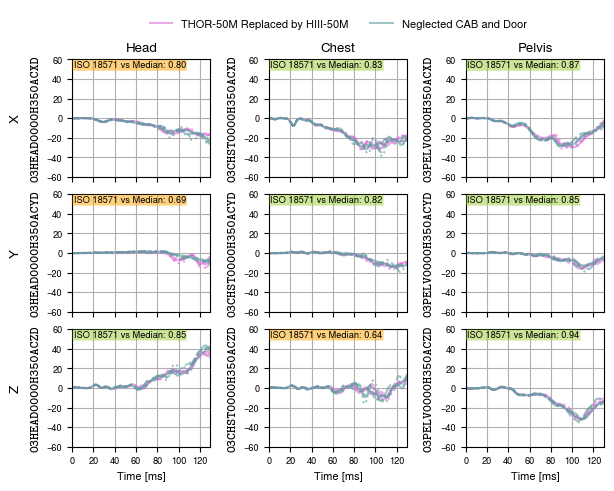

In [62]:
plot_occupant_cases_only_acc(case="ODB-R", cae_ref="400_HIII", cae_comp="600_NoDoor", alt_name_cae_ref="THOR-50M Replaced by HIII-50M", alt_name_cae_comp="Neglected CAB and Door", occu="H3")

2025-01-04 01:02:26,465     INFO  MainProcess  MainThread maxp pruned
2025-01-04 01:02:26,468     INFO  MainProcess  MainThread cmap pruned
2025-01-04 01:02:26,469     INFO  MainProcess  MainThread post pruned
2025-01-04 01:02:26,470     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 01:02:26,471     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 01:02:26,473     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 01:02:26,477     INFO  MainProcess  MainThread glyf pruned
2025-01-04 01:02:26,478     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 01:02:26,479     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 01:02:26,481     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2025-01-04 01:02:26,482     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'B', 'D', 'E', 'F', 'H', 'L', 'O', 'R', 'S', 'T', 'U', 'V', 'five', 'four', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-04 01:02:26,483  

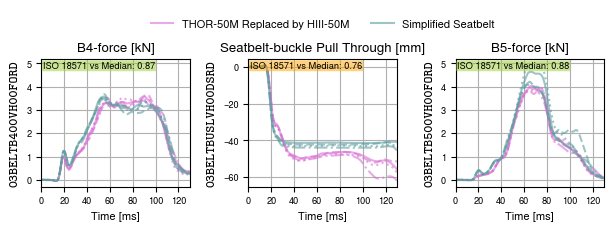

In [63]:
plot_around_belt_buckle(case="FWB", cae_ref="400_HIII", cae_comp="700_Simplified_Belt", alt_name_cae_ref="THOR-50M Replaced by HIII-50M", alt_name_cae_comp="Simplified Seatbelt")

2025-01-04 01:24:50,568     INFO  MainProcess  MainThread maxp pruned
2025-01-04 01:24:50,571     INFO  MainProcess  MainThread cmap pruned
2025-01-04 01:24:50,572     INFO  MainProcess  MainThread post pruned
2025-01-04 01:24:50,573     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 01:24:50,575     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 01:24:50,576     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 01:24:50,581     INFO  MainProcess  MainThread glyf pruned
2025-01-04 01:24:50,583     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 01:24:50,584     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 01:24:50,584     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 16 glyphs before
2025-01-04 01:24:50,585     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'D', 'E', 'F', 'H', 'I', 'L', 'M', 'O', 'R', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-04 01:24:50,586     INFO  MainProcess  M

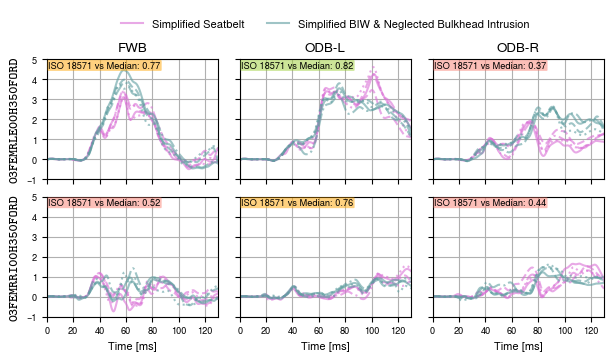

In [71]:
plot_femur_only(cae_ref="700_Simplified_Belt", cae_comp="900_NoIntrusion", alt_name_cae_ref="Simplified Seatbelt", alt_name_cae_comp="Simplified BIW & Neglected Bulkhead Intrusion", occu="H3", yticks=np.arange(-1,5.1,1))

2025-01-04 01:42:25,264     INFO  MainProcess  MainThread maxp pruned
2025-01-04 01:42:25,267     INFO  MainProcess  MainThread cmap pruned
2025-01-04 01:42:25,268     INFO  MainProcess  MainThread post pruned
2025-01-04 01:42:25,269     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 01:42:25,271     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 01:42:25,272     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 01:42:25,275     INFO  MainProcess  MainThread glyf pruned
2025-01-04 01:42:25,275     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 01:42:25,276     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 01:42:25,277     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 16 glyphs before
2025-01-04 01:42:25,277     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'D', 'E', 'F', 'H', 'I', 'L', 'M', 'O', 'R', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-04 01:42:25,279     INFO  MainProcess  M

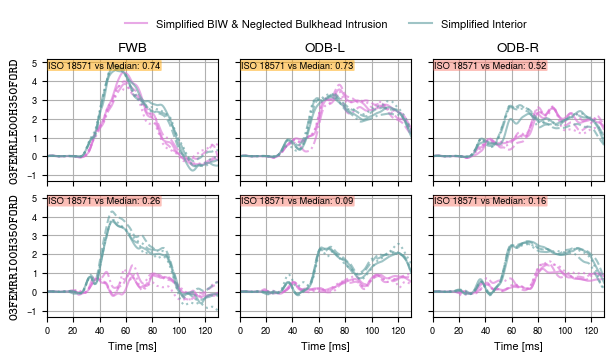

In [76]:
plot_femur_only(cae_ref="900_NoIntrusion", cae_comp="990_Carpet_Rigid", alt_name_cae_ref="Simplified BIW & Neglected Bulkhead Intrusion", alt_name_cae_comp="Simplified Interior", occu="H3", yticks=np.arange(-1,5.1,1))

2025-01-04 01:50:59,926     INFO  MainProcess  MainThread maxp pruned
2025-01-04 01:50:59,929     INFO  MainProcess  MainThread cmap pruned
2025-01-04 01:50:59,930     INFO  MainProcess  MainThread post pruned
2025-01-04 01:50:59,931     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 01:50:59,934     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 01:50:59,935     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 01:50:59,940     INFO  MainProcess  MainThread glyf pruned
2025-01-04 01:50:59,941     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 01:50:59,942     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 01:50:59,943     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 19 glyphs before
2025-01-04 01:50:59,945     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'B', 'D', 'E', 'F', 'H', 'L', 'O', 'R', 'T', 'V', 'five', 'four', 'glyph1', 'six', 'space', 'three', 'uni000D', 'zero']
2025-01-04 01:50:59,947     

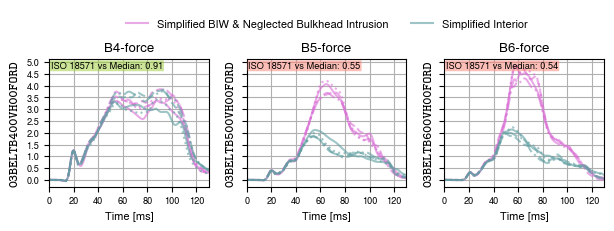

In [82]:
def plot_b5_b6_belt_buckle(case: str, cae_ref: str, cae_comp: str, alt_name_cae_ref: str,alt_name_cae_comp: str, close: bool = False):
    plots = [["03BELTB400VH00FORD", "03BELTB500VH00FORD", "03BELTB600VH00FORD"]]

    plots = [["none"] * 3, *plots]

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=True,
        layout="constrained",
        height_ratios=[0.01, 1],
    )

    # ax[plots[1][1]].sharey(ax[plots[1][-1]])

    for field in sum(plots, []):
        if field != "none":
            ch = field
            if field != "none":
                data = defaultdict(dict)
                for i, cae_name in enumerate(db_caes.keys()):
                    db_cae = db_caes[cae_name]
                    # plot CAE data
                    cae = db_cae[db_cae["Channel"].eq(ch) & db_cae["Case"].eq(case)]
                    isos = defaultdict(list)
                    for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                        cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

                        test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                        ax[field].plot(
                            test.index,
                            test,
                            c=NEW_CAES[i],
                            ls=LSS[j],
                            label=(alt_name_cae_comp if cae_name == cae_comp else alt_name_cae_ref) if j == 0 else "",
                            alpha=0.6,
                        )

                        data[cae_name][setting] = test

                # isos
                isos = []
                for setting in data[cae_ref].keys():
                    if setting in data[cae_comp] and setting in data[cae_ref]:
                        isos.append(
                            rating_iso_18571_short(
                                signal_ref=data[cae_ref][setting].loc[20:120].values,
                                signal_comp=data[cae_comp][setting].loc[20:120].values,
                            )
                        )

                add_textbox(
                    ax=ax[field],
                    j=0,
                    f1="ISO 18571",
                    f2="Median",
                    iso=np.median(isos),
                )

            ax[field].set_xlabel("Time [ms]")

            ax[field].set_ylabel(field, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
            ax[field].set_title(f"{field[6:8]}-force")

        ax[field].grid()
        ax[field].set_xlim([0, 130])
        ax[field].set_yticks(np.arange(0, 5.1, 0.5))

    ax["none"].set_axis_off()
    ax["none"].legend(*ax["03BELTB500VH00FORD"].get_legend_handles_labels(), loc="upper center", ncol=3)

    f_path = FIG_DIR / f"{cae_ref}_vs_{cae_comp}_{case}_b5_b6_belt_buckle.pdf"
    fig.set_figwidth(WIDTH)
    fig.set_figheight(2.2)
    fig.savefig(f_path)
    LOG.warning("Saved to %s", f_path)
    if close:
        plt.close(fig)


plot_b5_b6_belt_buckle(case="FWB", cae_ref="900_NoIntrusion", cae_comp="990_Carpet_Rigid", alt_name_cae_ref="Simplified BIW & Neglected Bulkhead Intrusion", alt_name_cae_comp="Simplified Interior")

In [ ]:
_ = [
    plot_occupant_cases(case=c, cae_ref="400_HIII", cae_comp="990_Carpet_Rigid", alt_name="HIII", close=False)
    for c in ("Full Frontal", "Moderate Overlap Left", "Moderate Overlap Right")
]

In [ ]:
_ = [
    plot_rhs_cases(case=c, cae_ref="400_HIII", cae_comp="990_Carpet_Rigid", alt_name="HIII", close=False)
    for c in ("Full Frontal", "Moderate Overlap Left", "Moderate Overlap Right")
]

In [ ]:
plot_femur_only(cae_ref="400_HIII", cae_comp="990_Carpet_Rigid", alt_name="HIII")

In [79]:
REL_CH = [
    "00COG00000VH00ACRD",
    "00COG00000VH00ACXD",
    "00COG00000VH00ACYD",
    "00COG00000VH00VEXD",
    "00COG00000VH00VEYD",
    "03BELTB000VH00DSRD",
    "03BELTB000VH00FORD",
    "03BELTB300VH00FORD",
    "03BELTB400VH00FORD",
    "03BELTB500VH00FORD",
    "03BELTB600VH00FORD",
    "03BELTBUSLVH00DSRD",
    "03FAB00000VH00PRRD",
    "03FAB00000VH00TPRD",
    "03FAB00000VH00VORD",
    "03HEAD0000H350ACRD",
    "03HEAD0000H350ACXD",
    "03HEAD0000H350ACYD",
    "03HEAD0000H350ACZD",
    "03HEADLOC0H350DSXD",
    "03HEADLOC0H350DSYD",
    "03HEADLOC0H350DSZD",
    "03CHST0000H350ACRD",
    "03CHST0000H350ACXD",
    "03CHST0000H350ACYD",
    "03CHST0000H350ACZD",
    "03CHSTLOC0H350DSXD",
    "03CHSTLOC0H350DSYD",
    "03CHSTLOC0H350DSZD",
    "03PELV0000H350ACRD",
    "03PELV0000H350ACXD",
    "03PELV0000H350ACYD",
    "03PELV0000H350ACZD",
    "03PELVLOC0H350DSXD",
    "03PELVLOC0H350DSYD",
    "03PELVLOC0H350DSZD",
    "03FEMRLE00H350FORD",
    "03FEMRRI00H350FORD",
]

In [81]:
def get_isos__and_injuries(cae_ref="400_HIII", cae_comp="990_Carpet_Rigid") -> pd.DataFrame:

    isos = defaultdict(dict)
    for lc in ("Full Frontal", "Moderate_Overlap_Left", "Moderate_Overlap_Right"):
        inner_isos = defaultdict(list)
        for ass in (1, 2, 3, 4):
            # get data
            db_caes = {}
            the_ch = set(REL_CH)
            for cae_name in (cae_ref, cae_comp):
                f_path = Path("/mnt/q/Val_Chain_Sims/AB_Testing") / cae_name / "extracted.csv.zip"
                LOG.info("Get data from %s", f_path)
                with ZipFile(f_path) as z:
                    db_caes[cae_name] = (
                        (
                            pl.scan_csv(z.read("extracted.csv"))
                            .filter(pl.col("Assembly").eq(f"Assemblies_{ass}"))
                            .filter(pl.col("Case").eq(lc))
                            .filter(pl.col("Channel").is_in(REL_CH))
                            .select(["Time", "Value", "Channel"])
                            .collect()
                        )
                        .to_pandas()
                        .set_index("Time")
                        .pivot(columns="Channel", values="Value")
                    )
                the_ch &= set(db_caes[cae_name].columns)

            # calculate rating
            for ch in REL_CH:
                LOG.info("Calculate Rating for %s of %s assembly %s", ch, lc, ass)
                if ch in the_ch:
                    t_start = 50 if ch.startswith("03FAB") else 20
                    inner_isos[ch].append(
                        rating_iso_18571_short(
                            signal_ref=db_caes[cae_ref][ch].loc[t_start:120].values,
                            signal_comp=db_caes[cae_comp][ch].loc[t_start:120].values,
                        )
                    )
                else:
                    inner_isos[ch].append(np.nan)

        # store
        LOG.info("Store")
        for ch in inner_isos.keys():
            isos[lc.replace("_", " ")][ch] = np.median(inner_isos[ch])

    return pd.DataFrame(isos)


ISOS = get_isos__and_injuries()
ISOS

2025-01-04 01:46:48,335     INFO  MainProcess  MainThread Get data from /mnt/q/Val_Chain_Sims/AB_Testing/400_HIII/extracted.csv.zip
2025-01-04 01:46:51,481     INFO  MainProcess  MainThread Get data from /mnt/q/Val_Chain_Sims/AB_Testing/990_Carpet_Rigid/extracted.csv.zip
2025-01-04 01:46:54,184     INFO  MainProcess  MainThread Calculate Rating for 00COG00000VH00ACRD of Full Frontal assembly 1
2025-01-04 01:46:54,237     INFO  MainProcess  MainThread Calculate Rating for 00COG00000VH00ACXD of Full Frontal assembly 1
2025-01-04 01:46:54,286     INFO  MainProcess  MainThread Calculate Rating for 00COG00000VH00ACYD of Full Frontal assembly 1
2025-01-04 01:46:54,329     INFO  MainProcess  MainThread Calculate Rating for 00COG00000VH00VEXD of Full Frontal assembly 1
2025-01-04 01:46:54,372     INFO  MainProcess  MainThread Calculate Rating for 00COG00000VH00VEYD of Full Frontal assembly 1
2025-01-04 01:46:54,412     INFO  MainProcess  MainThread Calculate Rating for 03BELTB000VH00DSRD of Fu

,Full Frontal,Moderate Overlap Left,Moderate Overlap Right
00COG00000VH00ACRD,0.999995,0.999991,0.999992
00COG00000VH00ACXD,0.999995,0.999994,0.999992
00COG00000VH00ACYD,0.999999,0.999992,0.999996
00COG00000VH00VEXD,1.000000,0.999997,0.999997
00COG00000VH00VEYD,1.000000,1.000000,1.000000
03BELTB000VH00DSRD,0.964645,0.728703,0.771496
03BELTB000VH00FORD,0.968684,0.964640,0.969899
03BELTB300VH00FORD,0.937377,0.918147,0.941623
03BELTB400VH00FORD,0.852369,0.766716,0.809505
03BELTB500VH00FORD,0.575600,0.485489,0.514441


In [85]:
ISOS.rename(columns={"Full Frontal":"FWB",	"Moderate Overlap Left":"ODB-L"	,"Moderate Overlap Right":"ODB-R"}, inplace=True)

2025-01-04 01:53:49,087     INFO  MainProcess  MainThread maxp pruned
2025-01-04 01:53:49,093     INFO  MainProcess  MainThread cmap pruned
2025-01-04 01:53:49,096     INFO  MainProcess  MainThread post pruned
2025-01-04 01:53:49,097     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 01:53:49,099     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 01:53:49,101     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 01:53:49,103     INFO  MainProcess  MainThread glyf pruned
2025-01-04 01:53:49,105     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 01:53:49,107     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 01:53:49,108     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 30 glyphs before
2025-01-04 01:53:49,109     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'five', 'four', 'glyph1', 'six', 'space', '

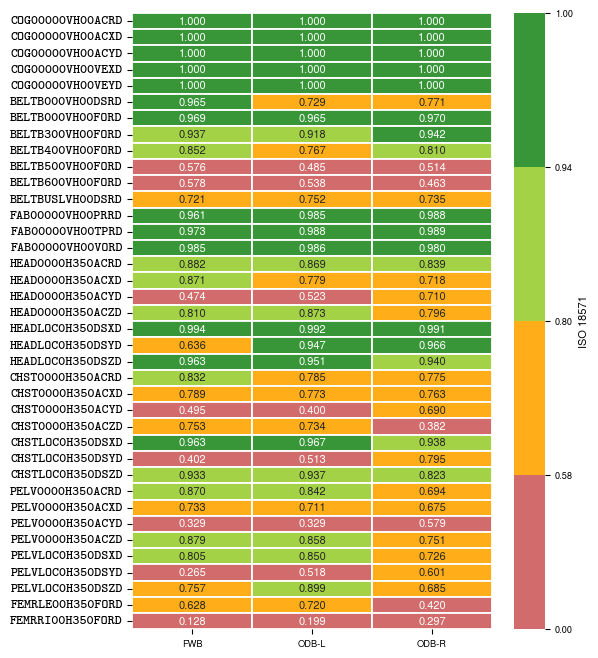

In [87]:
def plot_heatmap():
    fig, ax = plt.subplots()
    cmap = mpl.colors.ListedColormap(["indianred", "orange", "yellowgreen", "forestgreen"])
    bounds = [0, 0.58, 0.8, 0.94, 1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    sns.heatmap(
        ISOS.loc[REL_CH],
        vmin=0,
        vmax=1,
        ax=ax,
        annot=True,
        fmt=".3f",
        lw=0.2,
        cmap=cmap,
        norm=norm,
        yticklabels=[x[2:] for x in REL_CH],
        cbar_kws={"label": "ISO 18571"},
        alpha=0.9,
    )
    ax.set_yticklabels(ax.get_yticklabels(), **{"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.1 * WIDTH)
    fig.savefig(FIG_DIR / "iso_heatmap_ref_vs_final.pdf")


plot_heatmap()

In [ ]:
def get_maxis(cae_ref="400_HIII", cae_comp="990_Carpet_Rigid") -> pd.DataFrame:
    maxi_ch = [
        "03HEAD0000H350ACRD",
        "03CHST0000H350ACRD",
        "03PELV0000H350ACRD",
        "03FEMRLE00H350FORD",
        "03FEMRRI00H350FORD",
    ]

    isos = defaultdict(dict)
    for lc in ("Full Frontal", "Moderate_Overlap_Left", "Moderate_Overlap_Right"):
        inner_isos = defaultdict(list)
        for ass in (1, 2, 3, 4):
            # get data
            db_caes = {}
            the_ch = set(maxi_ch)
            for cae_name in (cae_ref, cae_comp):
                f_path = Path("/mnt/q/Val_Chain_Sims/AB_Testing") / cae_name / "extracted.csv.zip"
                LOG.info("Get data from %s", f_path)
                with ZipFile(f_path) as z:
                    db_caes[cae_name] = (
                        (
                            pl.scan_csv(z.read("extracted.csv"))
                            .filter(pl.col("Assembly").eq(f"Assemblies_{ass}"))
                            .filter(pl.col("Case").eq(lc))
                            .filter(pl.col("Channel").is_in(maxi_ch))
                            .select(["Time", "Value", "Channel"])
                            .collect()
                        )
                        .to_pandas()
                        .set_index("Time")
                        .pivot(columns="Channel", values="Value")
                    )
                the_ch &= set(db_caes[cae_name].columns)

            # calculate rating
            for ch in maxi_ch:
                LOG.info("Calculate Rating for %s of %s assembly %s", ch, lc, ass)
                if ch in the_ch:
                    inner_isos[ch].append(
                        db_caes[cae_ref][ch].loc[20:120].abs().max() - db_caes[cae_comp][ch].loc[20:120].abs().max()
                    )
                else:
                    inner_isos[ch].append(np.nan)

        # store
        LOG.info("Store")
        for ch in inner_isos.keys():
            isos[lc.replace("_", " ")][ch] = np.round(np.median(inner_isos[ch]), 2)

    return pd.DataFrame(isos)


get_maxis()

2025-01-04 02:07:07,063     INFO  MainProcess  MainThread maxp pruned
2025-01-04 02:07:07,066     INFO  MainProcess  MainThread cmap pruned
2025-01-04 02:07:07,067     INFO  MainProcess  MainThread post pruned
2025-01-04 02:07:07,068     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 02:07:07,069     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 02:07:07,070     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 02:07:07,075     INFO  MainProcess  MainThread glyf pruned
2025-01-04 02:07:07,076     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 02:07:07,076     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 02:07:07,077     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 15 glyphs before
2025-01-04 02:07:07,078     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'R', 'S', 'T', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2025-01-04 02:07:07,079     INFO  MainProcess  MainTh

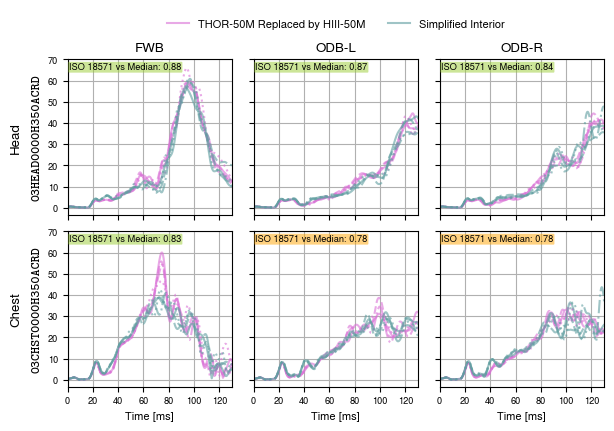

In [93]:
def plot_occupant_cases_only_acc(cae_ref: str, cae_comp: str, alt_name: str, new_name: str, close: bool = False):
    plots = [[f"03{part}0000??50ACRD${cs}" for cs in ("FWB", "ODB-L", "ODB-R")] for part in ("HEAD", "CHST")]
    part_parser = {"HEAD": "Head", "CHST": "Chest", "PELV": "Pelvis"}

    plots = [["none"] * 3, *plots]

    db_caes = {c: get_new_cae(model=c) for c in (cae_ref, cae_comp)}

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=True,
        layout="constrained",
        height_ratios=[0.01, *([1] * 2)],
    )

    for field in sum(plots, []):
        if field != "none":
            ch, case = field.split("$")
            data = defaultdict(dict)
            for i, cae_name in enumerate(db_caes.keys()):
                db_cae = db_caes[cae_name]
                # plot CAE data
                cae = db_cae[db_cae["Channel"].eq(ch) & db_cae["Case"].eq(case)]
                isos = defaultdict(list)
                for j, setting in enumerate(sorted(cae["Assembly"].unique())):
                    cae2 = cae[cae["Assembly"].eq(setting)].sort_values("Time")

                    test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                    ax[field].plot(
                        test.index,
                        test,
                        c=NEW_CAES[i],
                        ls=LSS[j],
                        label=(new_name if cae_name == cae_comp else alt_name) if j == 0 else "",
                        alpha=0.6,
                    )

                    data[cae_name][setting] = test

            # isos
            isos = []
            for setting in data[cae_ref].keys():
                if setting in data[cae_comp] and setting in data[cae_ref]:
                    isos.append(
                        rating_iso_18571_short(
                            signal_ref=data[cae_ref][setting].loc[20:120].values,
                            signal_comp=data[cae_comp][setting].loc[20:120].values,
                        )
                    )

            add_textbox(
                ax=ax[field],
                j=0,
                f1="ISO 18571",
                f2="Median",
                iso=np.median(isos),
            )

            ax[field].set_yticks(np.arange(0, 71, 10))

            if field in plots[1]:
                ax[field].set_title(case)
            if field in plots[-1]:
                ax[field].set_xlabel("Time [ms]")
            if case == "FWB":
                ax[field].annotate(
                    part_parser[ch[2:6]],
                    (-0.35, 0.5),
                    rotation=90,
                    va="center",
                    xycoords="axes fraction",
                    fontsize="large",
                )
                ax[field].set_ylabel(ch.replace("??", "H3"), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})

        ax[field].grid()
        ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax[plots[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)

    f_path = FIG_DIR / f"{cae_ref}_vs_{cae_comp}_occupant_res_acc.pdf"
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.4 * 3)
    fig.savefig(f_path)
    LOG.warning("Saved to %s", f_path)
    if close:
        plt.close(fig)


plot_occupant_cases_only_acc(
    cae_ref="400_HIII", cae_comp="990_Carpet_Rigid", alt_name="THOR-50M Replaced by HIII-50M", new_name="Simplified Interior"
)

2025-01-03 21:32:05,914     INFO  MainProcess  MainThread maxp pruned
2025-01-03 21:32:05,918     INFO  MainProcess  MainThread cmap pruned
2025-01-03 21:32:05,919     INFO  MainProcess  MainThread post pruned
2025-01-03 21:32:05,921     INFO  MainProcess  MainThread FFTM dropped
2025-01-03 21:32:05,923     INFO  MainProcess  MainThread GPOS pruned
2025-01-03 21:32:05,927     INFO  MainProcess  MainThread GSUB pruned
2025-01-03 21:32:05,931     INFO  MainProcess  MainThread glyf pruned
2025-01-03 21:32:05,932     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-03 21:32:05,933     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-03 21:32:05,934     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 15 glyphs before
2025-01-03 21:32:05,935     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'G', 'H', 'O', 'V', 'X', 'Y', 'glyph1', 'space', 'uni000D', 'zero']
2025-01-03 21:32:05,937     INFO  MainProcess  MainThread Gl

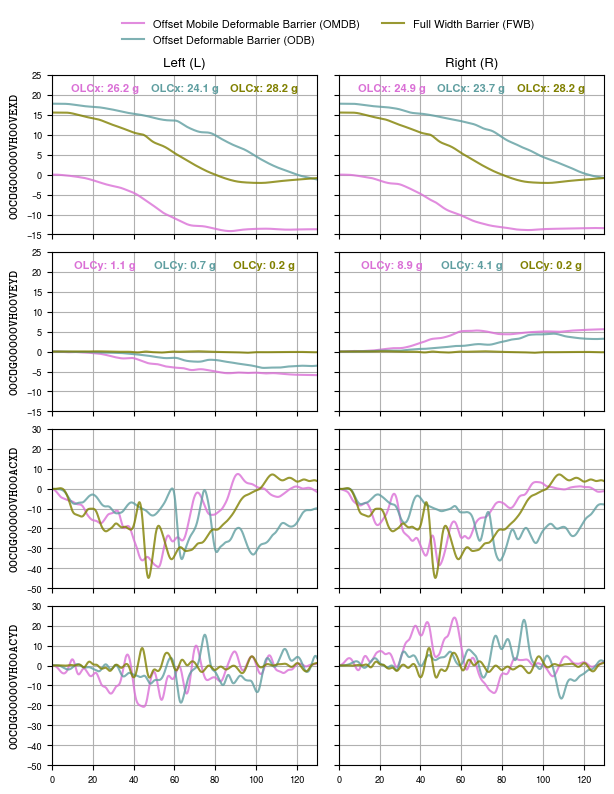

In [16]:
def plot_pulse_obique_vs_moderate():
    channels = ["00COG00000VH00VEXD", "00COG00000VH00VEYD", "00COG00000VH00ACXD", "00COG00000VH00ACYD"]
    units = ["X-Velocity Change [m/s]", "Y-Velocity [m/s]", "X-Acceleration [g]", "Y Acceleration [g]"]
    cases = ["L", "R"]
    dic = {
        "ODB": "Offset Deformable Barrier",
        "OMDB": "Offset Mobile Deformable Barrier",
        "FWB": "Full Width Barrier",
        "L": "Left",
        "R": "Right",
    }

    plots = [[f"{channel}${case}" for case in cases] for channel in channels]
    plots = [["none"] * len(cases), *plots]

    y_ranges = {1: [-15, 25], 2: [-15, 25], 3: [-50, 30], 4: [-50, 30]}

    db_cae = get_new_cae(model="000_Base_Model")

    fig, ax = plt.subplot_mosaic(
        mosaic=plots,
        sharex=True,
        sharey=False,
        layout="constrained",
        height_ratios=[0.01, *([1] * len(channels))],
    )

    for col, case_ in enumerate(cases):
        ts = {}
        for row, channel in enumerate(channels):

            field = f"{channel}${case_}"

            for k, barrier in enumerate(["OMDB", "ODB", "FWB"]):
                if barrier == "FWB":
                    case = barrier
                else:
                    case = f"{barrier}-{case_}"

                # cae data
                cae = db_cae[
                    db_cae["Channel"].eq(channel) & db_cae["Case"].eq(case) & (db_cae["Side"].eq("PA") | db_cae["Side"].isna())
                ]

                # plot single curves
                cae2 = cae[cae["Assembly"].eq("SP 48")].sort_values("Time")
                test = UNIFIER.unify(db=cae2[["Time", "Value"]].set_index("Time"))["Value"]

                if channel == "00COG00000VH00VEXD":
                    olc, t1, t2 = get_olc(channel=test, scal_x2s=1e-3)
                    ts[barrier] = (t1, t2)
                    positions = (0.2, 0.5, 0.8)
                    ax[field].annotate(
                        f"OLCx: {olc:.1f} g",
                        (positions[k], 0.9),
                        xycoords="axes fraction",
                        ha="center",
                        c=NEW_CAES[k],
                        fontweight="bold",
                    )
                elif channel == "00COG00000VH00VEYD":
                    olc_y = (abs(test.min() - test.loc[ts[barrier][1] * 1000]) / (ts[barrier][1] - ts[barrier][0])) / sconst.g
                    ax[field].annotate(
                        f"OLCy: {olc_y:.1f} g",
                        (positions[k], 0.9),
                        xycoords="axes fraction",
                        ha="center",
                        c=NEW_CAES[k],
                        fontweight="bold",
                    )

                # if barrier in {"Moderate Overlap", "Full Frontal"} and channel == "00COG00000VH00VEXD":
                #    test -= test.loc[0]

                ax[field].plot(test.index, test, c=NEW_CAES[k], ls="-", label=f"{dic[barrier]} ({barrier})", alpha=0.8)

            # format
            if row == 0:
                ax[field].set_title(f"{dic[case_]} ({case_})")
            if col == 0:
                ax[field].set_ylabel(channel, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
                # ax[field].annotate(units[row], (-0.25, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")
            ax[field].set_ylim(y_ranges[row + 1])
            if col != 0:
                ax[field].set_yticklabels([])
            if row == 4:
                ax[field].set_xlabel("Time [ms]")
            ax[field].grid()
            ax[field].set_xlim([0, 130])

    ax["none"].set_axis_off()
    ax["none"].legend(*ax[plots[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)

    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.3 * WIDTH)
    fig.align_ylabels(list(ax.values()))
    fig.savefig(FIG_DIR / "base_model_pulse_oblque_vs_mol.pdf")


plot_pulse_obique_vs_moderate()

In [95]:
def get_virthuman_val_data(versions: List[str] = ["LS-Dyna_HIII", "VPS_HIII"]) -> Dict[str, pd.DataFrame]:
    paths = {
        "LS-Dyna_HIII": Path("/mnt/q/AWARE2ALL/original_model_dyna"),
        "VPS_HIII": Path("/mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT"),
        "VPS_VH05": Path("/mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT"),
        "VPS_VH50": Path("/mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT"),
        "VPS_VH95": Path("/mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT"),
    }
    [LOG.info("File %s exists: %s", p, p.is_dir()) for p in paths.values()]

    dbs = {}
    for vs in versions:
        LOG.info("Get data from %s", paths[vs])
        with ZipFile(paths[vs] / "extracted.csv.zip") as z:
            dbs[vs] = (pl.scan_csv(z.read("extracted.csv")).collect()).to_pandas().set_index("TIME")
    return dbs


get_virthuman_val_data()

2025-01-04 02:11:06,342     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 02:11:06,352     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 02:11:06,357     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 02:11:06,361     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 02:11:06,376     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 02:11:06,377     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna
2025-01-04 02:11:06,509     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFro

{'LS-Dyna_HIII':        00COG00000VH00VEXX  00COG00000VH00VEYX  00COG00000VH00ACYX  \
 TIME                                                                
 0.0               15.5599             -0.0035              0.0000   
 0.1               15.5599             -0.0035              0.0000   
 0.2               15.5598             -0.0035              0.0000   
 0.3               15.5596             -0.0035              0.0001   
 0.4               15.5594             -0.0035              0.0001   
 ...                   ...                 ...                 ...   
 139.6             -0.1866              0.0000             -0.0026   
 139.7             -0.1832              0.0000              0.0005   
 139.8             -0.1797              0.0000             -0.0004   
 139.9             -0.1762              0.0000             -0.0009   
 140.0             -0.1986              0.0000             -0.0010   
 
        00COG00000VH00ACXX  01FAB00000VH00PRRX  01FAB00000VH00VORX  \
 T

2025-01-04 10:27:39,347     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 10:27:39,353     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 10:27:39,357     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 10:27:39,380     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 10:27:39,385     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 10:27:39,386     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna
2025-01-04 10:27:39,518     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFro

2025-01-04 10:27:40,318  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/LS-Dyna_HIII_vs_VPS_HIII_ab_pulse.pdf
2025-01-04 10:27:41,774     INFO  MainProcess  MainThread maxp pruned
2025-01-04 10:27:41,777     INFO  MainProcess  MainThread cmap pruned
2025-01-04 10:27:41,778     INFO  MainProcess  MainThread post pruned
2025-01-04 10:27:41,780     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 10:27:41,781     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 10:27:41,783     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 10:27:41,787     INFO  MainProcess  MainThread glyf pruned
2025-01-04 10:27:41,788     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 10:27:41,789     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 10:27:41,790     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 15 glyphs before
2025-01-04 10:27:41,791

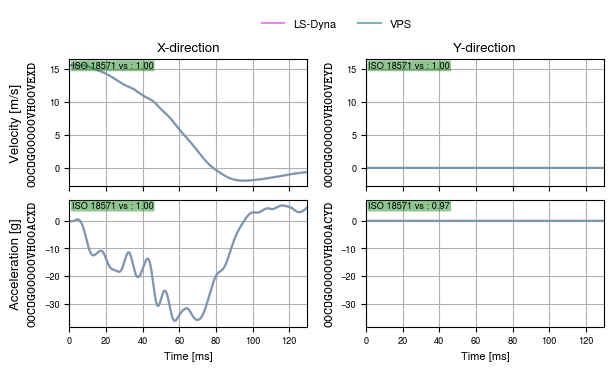

In [115]:
def plot_ab_pulse(ref: str = "LS-Dyna_HIII", comp: str = "VPS_HIII", close: bool = False):
    dbs = get_virthuman_val_data(versions=[ref, comp])
    channels = [["00COG00000VH00VEXD", "00COG00000VH00VEYD"], ["00COG00000VH00ACXD", "00COG00000VH00ACYD"]]
    channels = [["none"] * 2, *channels]

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1]
    )
    ax[channels[1][0]].sharey(ax[channels[1][1]])
    ax[channels[2][0]].sharey(ax[channels[2][1]])

    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref][channel].loc[20:120].values,
            signal_comp=dbs[comp][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref, comp]):
            ax[channel].plot(
                dbs[version].index, dbs[version][channel], c=NEW_CAES[i], label=version.replace("_", " - ").split()[0], alpha=0.8
            )

        if channel in channels[1]:
            ax[channel].set_title(f"{channel[-2:-1]}-direction")
        if channel in channels[2]:
            ax[channel].set_xlabel("Time [ms]")
        if channel.endswith("XD"):
            txt = "Velocity [m/s]" if channel.endswith("VEXD") else "Acceleration [g]"
            ax[channel].annotate(txt, (-0.25, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")
        ax[channel].set_ylabel(channel, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_pulse.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.8 * 2)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_pulse()

2025-01-04 10:37:26,101     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 10:37:26,168     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 10:37:26,216     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 10:37:26,221     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 10:37:26,224     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 10:37:26,225     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna
2025-01-04 10:37:26,324     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFro

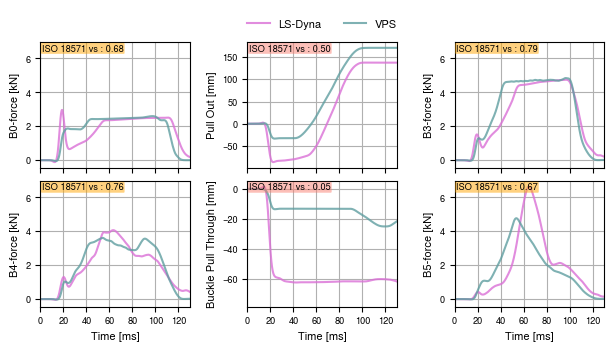

In [122]:
def plot_ab_belt(ref: str = "LS-Dyna_HIII", comp: str = "VPS_HIII", close: bool = False):
    dbs = get_virthuman_val_data(versions=[ref, comp])
    channels = [
        ["03BELTB000VH00FORD", "03BELTB000VH00DSRD", "03BELTB300VH00FORD"],
        ["03BELTB400VH00FORD", "03BELTBUSLVH00DSRD", "03BELTB500VH00FORD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]

    fig, ax = plt.subplot_mosaic(
        mosaic=channels,  sharex=True, layout="constrained", height_ratios=[0.01, 1, 1]
    )
    ax[channels[1][0]].sharey(ax[channels[1][2]])
    ax[channels[1][2]].sharey(ax[channels[2][0]])
    ax[channels[2][0]].sharey(ax[channels[2][2]])

    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref][channel].loc[20:120].values,
            signal_comp=dbs[comp][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref, comp]):
            ax[channel].plot(
                dbs[version].index, dbs[version][channel], c=NEW_CAES[i], label=version.replace("_", " - ").split()[0], alpha=0.8
            )

        if channel.endswith("FORD"):
            txt = f"{channel[6:8]}-force [kN]"
        else:
            if "BUS" in channel:
                txt = "Buckle Pull Through [mm]"
            else:
                txt = "Pull Out [mm]"
        ax[channel].set_ylabel(txt)

        if channel in channels[2]:
            ax[channel].set_xlabel("Time [ms]")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_belt.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.7 * 2)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_belt()

2025-01-04 10:35:37,884     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 10:35:37,889     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 10:35:37,893     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 10:35:37,897     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 10:35:37,901     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 10:35:37,904     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna
2025-01-04 10:35:38,006     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFro

2025-01-04 10:35:38,616  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/LS-Dyna_HIII_vs_VPS_HIII_ab_pab.pdf
2025-01-04 10:35:40,754     INFO  MainProcess  MainThread maxp pruned
2025-01-04 10:35:40,765     INFO  MainProcess  MainThread cmap pruned
2025-01-04 10:35:40,767     INFO  MainProcess  MainThread post pruned
2025-01-04 10:35:40,769     INFO  MainProcess  MainThread CFF  pruned
2025-01-04 10:35:40,775     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 10:35:40,812     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 10:35:40,818     INFO  MainProcess  MainThread Added .notdef to subset
2025-01-04 10:35:40,819     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 44 glyphs before
2025-01-04 10:35:40,822     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'D', 'I', 'K', 'L', 'M', 'O', 'P', 'R', 'S', 'T', 'V', 'a', 'b', 'bracketleft', 'bracketright', 'colon

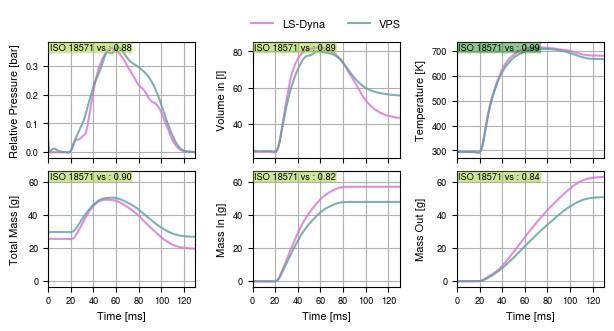

In [121]:
def plot_ab_fab(ref: str = "LS-Dyna_HIII", comp: str = "VPS_HIII", close: bool = False):
    dbs = get_virthuman_val_data(versions=[ref, comp])
    channels = [
        ["03FAB00000VH00PRRD", "03FAB00000VH00VORD", "03FAB00000VH00TPRD"],
        ["03FAB00000VH00TMRD", "03FAB00000VH00IMRD", "03FAB00000VH00OMRD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1]
    )
    ax[channels[2][0]].sharey(ax[channels[2][1]])
    ax[channels[2][1]].sharey(ax[channels[2][2]])
    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref][channel].loc[20:120].values,
            signal_comp=dbs[comp][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref, comp]):
            ax[channel].plot(
                dbs[version].index, dbs[version][channel], c=NEW_CAES[i], label=version.replace("_", " - ").split()[0], alpha=0.8
            )

        if channel in channels[2]:
            ax[channel].set_xlabel("Time [ms]")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

        labels = {
            "VO": "Volume in [l]",
            "PR": "Relative Pressure [bar]",
            "TP": "Temperature [K]",
            "IM": "Mass In [g]",
            "OM": "Mass Out [g]",
            "TM": "Total Mass [g]",
        }
        ax[channel].set_ylabel(labels[channel[-4:-2]])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_pab.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.6 * 2)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_fab()

2025-01-04 10:43:21,264     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 10:43:21,279     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 10:43:21,301     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 10:43:21,307     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 10:43:21,311     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 10:43:21,312     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna
2025-01-04 10:43:21,405     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFro

2025-01-04 10:43:23,487  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/LS-Dyna_HIII_vs_VPS_HIII_ab_kinematics.pdf
2025-01-04 10:43:26,754     INFO  MainProcess  MainThread maxp pruned
2025-01-04 10:43:26,757     INFO  MainProcess  MainThread cmap pruned
2025-01-04 10:43:26,758     INFO  MainProcess  MainThread post pruned
2025-01-04 10:43:26,759     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 10:43:26,762     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 10:43:26,763     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 10:43:26,767     INFO  MainProcess  MainThread glyf pruned
2025-01-04 10:43:26,769     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 10:43:26,771     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 10:43:26,772     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2025-01-04 10:43:2

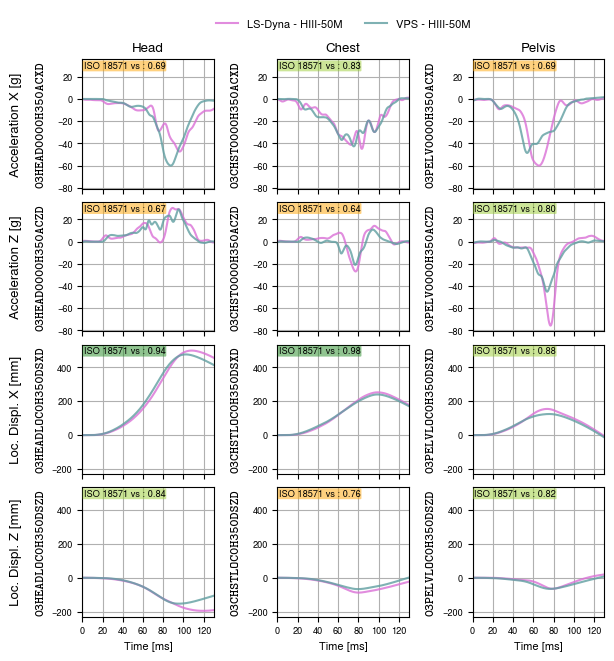

In [126]:
def plot_ab_kinematics(ref: str = "LS-Dyna_HIII", comp: str = "VPS_HIII", close: bool = False):
    dbs = get_virthuman_val_data(versions=[ref, comp])
    channels = [
        ["03HEAD0000H350ACXD", "03CHST0000H350ACXD", "03PELV0000H350ACXD"],
        ["03HEAD0000H350ACZD", "03CHST0000H350ACZD", "03PELV0000H350ACZD"],
        ["03HEADLOC0H350DSXD", "03CHSTLOC0H350DSXD", "03PELVLOC0H350DSXD"],
        ["03HEADLOC0H350DSZD", "03CHSTLOC0H350DSZD", "03PELVLOC0H350DSZD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]
    part_repl = {"HEAD": "Head", "CHST": "Chest", "PELV": "Pelvis"}

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, figsize=(WIDTH, 7), sharex=True, layout="constrained", height_ratios=[0.01, 1, 1, 1, 1]
    )

    ax[channels[1][0]].sharey(ax[channels[1][1]])
    ax[channels[1][1]].sharey(ax[channels[1][2]])
    ax[channels[1][2]].sharey(ax[channels[2][0]])
    ax[channels[2][0]].sharey(ax[channels[2][1]])
    ax[channels[2][1]].sharey(ax[channels[2][2]])

    ax[channels[3][0]].sharey(ax[channels[3][1]])
    ax[channels[3][1]].sharey(ax[channels[3][2]])
    ax[channels[3][2]].sharey(ax[channels[4][0]])
    ax[channels[4][0]].sharey(ax[channels[4][1]])
    ax[channels[4][1]].sharey(ax[channels[4][2]])

    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref][channel].loc[20:120].values,
            signal_comp=dbs[comp][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref, comp]):
            ax[channel].plot(
                dbs[version].index, dbs[version][channel], c=NEW_CAES[i], label=f'{version.replace("_", " - ")}-50M', alpha=0.8
            )

        ax[channel].set_ylabel(channel, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        if channel in channels[-1]:
            ax[channel].set_xlabel("Time [ms]")

        if channel in channels[1]:
            ax[channel].set_title(part_repl[channel[2:6]])

        if channel[2:6] == "HEAD":
            if channel[-4:-2] == "AC":
                txt = f"Acceleration {channel[-2]} [g]"
            else:
                txt = f"Loc. Displ. {channel[-2]} [mm]"

            ax[channel].annotate(txt, (-0.55, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_kinematics.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.3 * 5)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_kinematics()

2025-01-04 02:29:34,381     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 02:29:34,418     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 02:29:34,452     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 02:29:34,458     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 02:29:34,463     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 02:29:34,465     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna


2025-01-04 02:29:38,977  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/990_Carpet_Rigid_vs_LS-Dyna_HIII_ab_kinematics_transit.pdf
2025-01-04 02:29:42,791     INFO  MainProcess  MainThread maxp pruned
2025-01-04 02:29:42,795     INFO  MainProcess  MainThread cmap pruned
2025-01-04 02:29:42,796     INFO  MainProcess  MainThread post pruned
2025-01-04 02:29:42,797     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 02:29:42,798     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 02:29:42,801     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 02:29:42,806     INFO  MainProcess  MainThread glyf pruned
2025-01-04 02:29:42,808     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 02:29:42,810     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 02:29:42,811     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
20

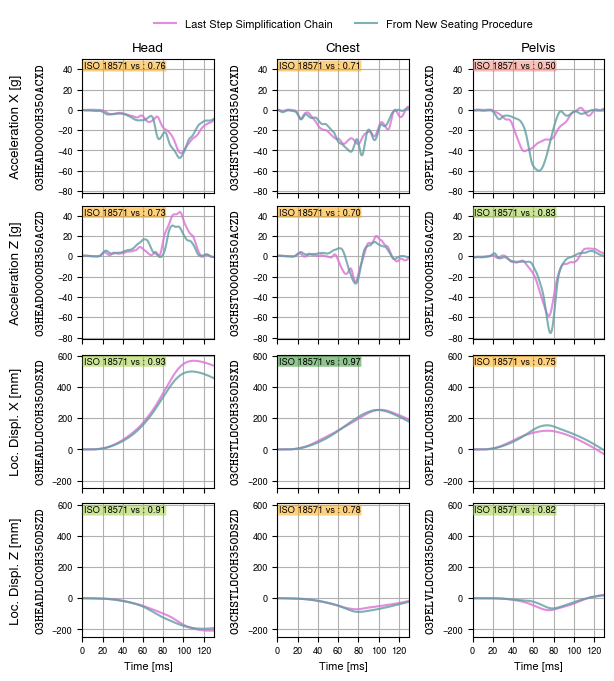

In [107]:
def plot_ab_kinematics_transit(
    ref: str = "990_Carpet_Rigid",
    comp: str = "LS-Dyna_HIII",
    ref_alt_name: str = "Last Step Simplification Chain",
    comp_alt_name: str = "From New Seating Procedure",
    close: bool = False,
):
    dbs = {comp_alt_name: get_virthuman_val_data(versions=[comp])[comp]}
    with ZipFile(Path("/mnt/q/Val_Chain_Sims/AB_Testing") / ref / "extracted.csv.zip") as z:
        dbs[ref_alt_name] = (
            (
                pl.scan_csv(z.read("extracted.csv"))
                .filter(pl.col("Assembly").eq(f"Assemblies_1"))
                .filter(pl.col("Case").eq("Full Frontal"))
                .select(["Time", "Value", "Channel"])
                .collect()
            )
            .to_pandas()
            .set_index("Time")
            .pivot(columns="Channel", values="Value")
        )

    channels = [
        ["03HEAD0000H350ACXD", "03CHST0000H350ACXD", "03PELV0000H350ACXD"],
        ["03HEAD0000H350ACZD", "03CHST0000H350ACZD", "03PELV0000H350ACZD"],
        ["03HEADLOC0H350DSXD", "03CHSTLOC0H350DSXD", "03PELVLOC0H350DSXD"],
        ["03HEADLOC0H350DSZD", "03CHSTLOC0H350DSZD", "03PELVLOC0H350DSZD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]
    part_dict = {"HEAD": "Head", "CHST": "Chest", "PELV": "Pelvis"}

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1, 1, 1]
    )

    ax[channels[1][0]].sharey(ax[channels[1][1]])
    ax[channels[1][1]].sharey(ax[channels[1][2]])
    ax[channels[1][2]].sharey(ax[channels[2][0]])
    ax[channels[2][0]].sharey(ax[channels[2][1]])
    ax[channels[2][1]].sharey(ax[channels[2][2]])

    ax[channels[3][0]].sharey(ax[channels[3][1]])
    ax[channels[3][1]].sharey(ax[channels[3][2]])
    ax[channels[3][2]].sharey(ax[channels[4][0]])
    ax[channels[4][0]].sharey(ax[channels[4][1]])
    ax[channels[4][1]].sharey(ax[channels[4][2]])

    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref_alt_name][channel].loc[20:120].values,
            signal_comp=dbs[comp_alt_name][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref_alt_name, comp_alt_name]):
            ax[channel].plot(
                dbs[version].index, dbs[version][channel], c=NEW_CAES[i], label=version.replace("_", " - "), alpha=0.8
            )

        ax[channel].set_ylabel(channel, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        if channel in channels[-1]:
            ax[channel].set_xlabel("Time [ms]")

        if channel in channels[1]:
            ax[channel].set_title(part_dict[channel[2:6]])

        if channel[2:6] == "HEAD":
            if channel[-4:-2] == "AC":
                txt = f"Acceleration {channel[-2]} [g]"
            else:
                txt = f"Loc. Displ. {channel[-2]} [mm]"

            ax[channel].annotate(txt, (-0.55, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_kinematics_transit.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(6.7)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_kinematics_transit()

2025-01-04 02:13:32,419     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 02:13:32,425     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 02:13:32,429     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 02:13:32,439     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 02:13:32,443     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 02:13:32,444     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna


2025-01-04 02:13:36,157  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/990_Carpet_Rigid_vs_LS-Dyna_HIII_ab_pulse_transit.pdf
2025-01-04 02:13:36,938     INFO  MainProcess  MainThread maxp pruned
2025-01-04 02:13:36,941     INFO  MainProcess  MainThread cmap pruned
2025-01-04 02:13:36,942     INFO  MainProcess  MainThread post pruned
2025-01-04 02:13:36,943     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 02:13:36,945     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 02:13:36,946     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 02:13:36,948     INFO  MainProcess  MainThread glyf pruned
2025-01-04 02:13:36,949     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 02:13:36,949     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 02:13:36,950     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 15 glyphs before
2025-01

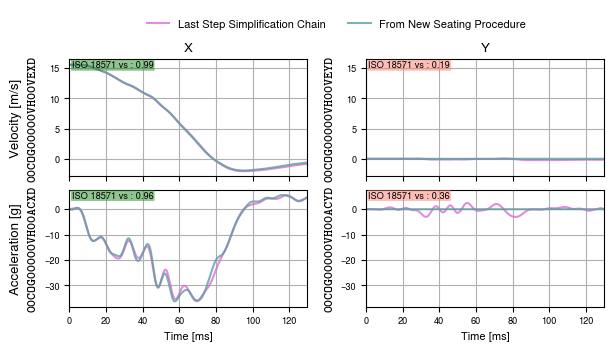

In [99]:
def plot_ab_pulse_transit(
    ref: str = "990_Carpet_Rigid",
    comp: str = "LS-Dyna_HIII",
    ref_alt_name: str = "Last Step Simplification Chain",
    comp_alt_name: str = "From New Seating Procedure",
    close: bool = False,
):
    dbs = {comp_alt_name: get_virthuman_val_data(versions=[comp])[comp]}
    with ZipFile(Path("/mnt/q/Val_Chain_Sims/AB_Testing") / ref / "extracted.csv.zip") as z:
        dbs[ref_alt_name] = (
            (
                pl.scan_csv(z.read("extracted.csv"))
                .filter(pl.col("Assembly").eq(f"Assemblies_1"))
                .filter(pl.col("Case").eq("Full Frontal"))
                .select(["Time", "Value", "Channel"])
                .collect()
            )
            .to_pandas()
            .set_index("Time")
            .pivot(columns="Channel", values="Value")
        )
    channels = [["00COG00000VH00VEXD", "00COG00000VH00VEYD"], ["00COG00000VH00ACXD", "00COG00000VH00ACYD"]]
    channels = [["none"] * 2, *channels]

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1]
    )
    ax[channels[1][0]].sharey(ax[channels[1][1]])
    ax[channels[2][0]].sharey(ax[channels[2][1]])

    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref_alt_name][channel].loc[20:120].values * -1,
            signal_comp=dbs[comp_alt_name][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref_alt_name, comp_alt_name]):
            flip = -1 if version == ref_alt_name else 1
            ax[channel].plot(
                dbs[version].index, dbs[version][channel] * flip, c=NEW_CAES[i], label=version.replace("_", " - "), alpha=0.8
            )

        ax[channel].set_ylabel(channel, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        if channel in channels[1]:
            ax[channel].set_title(channel[-2:-1])
        if channel in channels[2]:
            ax[channel].set_xlabel("Time [ms]")
        if channel.endswith("XD"):
            txt = "Velocity [m/s]" if channel.endswith("VEXD") else "Acceleration [g]"
            ax[channel].annotate(txt, (-0.25, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_pulse_transit.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.7 * 2)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_pulse_transit()

2025-01-04 02:18:09,653     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 02:18:09,658     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 02:18:09,675     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 02:18:09,684     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 02:18:09,688     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 02:18:09,689     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna


2025-01-04 02:18:13,397  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/990_Carpet_Rigid_vs_LS-Dyna_HIII_ab_belt_transit.pdf
2025-01-04 02:18:15,252     INFO  MainProcess  MainThread maxp pruned
2025-01-04 02:18:15,273     INFO  MainProcess  MainThread cmap pruned
2025-01-04 02:18:15,275     INFO  MainProcess  MainThread post pruned
2025-01-04 02:18:15,278     INFO  MainProcess  MainThread CFF  pruned
2025-01-04 02:18:15,282     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 02:18:15,305     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 02:18:15,307     INFO  MainProcess  MainThread Added .notdef to subset
2025-01-04 02:18:15,308     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 48 glyphs before
2025-01-04 02:18:15,312     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'B', 'C', 'F', 'I', 'L', 'N', 'O', 'P', 'S', 'T', 'a', 'bracketleft', 'bracketright',

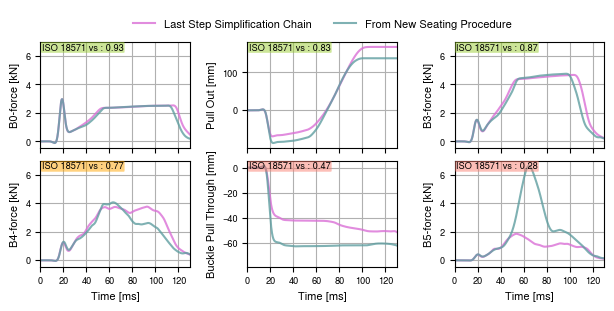

In [100]:
def plot_ab_belt_transit(
    ref: str = "990_Carpet_Rigid",
    comp: str = "LS-Dyna_HIII",
    ref_alt_name: str = "Last Step Simplification Chain",
    comp_alt_name: str = "From New Seating Procedure",
    close: bool = False,
):
    dbs = {comp_alt_name: get_virthuman_val_data(versions=[comp])[comp]}
    with ZipFile(Path("/mnt/q/Val_Chain_Sims/AB_Testing") / ref / "extracted.csv.zip") as z:
        dbs[ref_alt_name] = (
            (
                pl.scan_csv(z.read("extracted.csv"))
                .filter(pl.col("Assembly").eq(f"Assemblies_1"))
                .filter(pl.col("Case").eq("Full Frontal"))
                .select(["Time", "Value", "Channel"])
                .collect()
            )
            .to_pandas()
            .set_index("Time")
            .pivot(columns="Channel", values="Value")
        )
    channels = [
        ["03BELTB000VH00FORD", "03BELTB000VH00DSRD", "03BELTB300VH00FORD"],
        ["03BELTB400VH00FORD", "03BELTBUSLVH00DSRD", "03BELTB500VH00FORD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1]
    )
    ax[channels[1][0]].sharey(ax[channels[1][2]])
    ax[channels[1][2]].sharey(ax[channels[2][0]])
    ax[channels[2][0]].sharey(ax[channels[2][2]])

    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref_alt_name][channel].loc[20:120].values,
            signal_comp=dbs[comp_alt_name][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref_alt_name, comp_alt_name]):
            ax[channel].plot(
                dbs[version].index, dbs[version][channel], c=NEW_CAES[i], label=version.replace("_", " - "), alpha=0.8
            )

        if channel.endswith("FORD"):
            txt = f"{channel[6:8]}-force [kN]"
        else:
            if "BUS" in channel:
                txt = "Buckle Pull Through [mm]"
            else:
                txt = "Pull Out [mm]"
        ax[channel].set_ylabel(txt)

        if channel in channels[2]:
            ax[channel].set_xlabel("Time [ms]")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_belt_transit.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.5 * 2)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_belt_transit()

2025-01-04 10:19:34,871     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 10:19:34,879     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 10:19:34,884     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 10:19:34,889     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 10:19:34,893     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 10:19:34,894     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/original_model_dyna
2025-01-04 10:19:39,940  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_

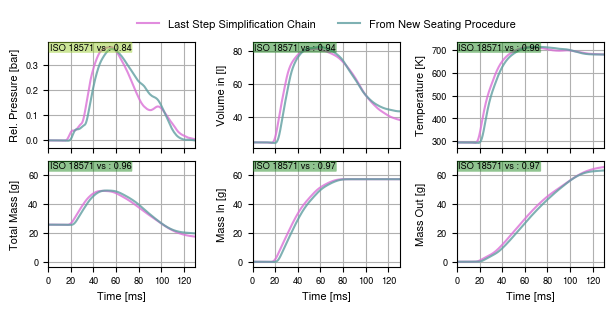

In [109]:
def plot_ab_fab_transit(
    ref: str = "990_Carpet_Rigid",
    comp: str = "LS-Dyna_HIII",
    ref_alt_name: str = "Last Step Simplification Chain",
    comp_alt_name: str = "From New Seating Procedure",
    close: bool = False,
):
    dbs = {comp_alt_name: get_virthuman_val_data(versions=[comp])[comp]}
    with ZipFile(Path("/mnt/q/Val_Chain_Sims/AB_Testing") / ref / "extracted.csv.zip") as z:
        dbs[ref_alt_name] = (
            (
                pl.scan_csv(z.read("extracted.csv"))
                .filter(pl.col("Assembly").eq(f"Assemblies_1"))
                .filter(pl.col("Case").eq("Full Frontal"))
                .select(["Time", "Value", "Channel"])
                .collect()
            )
            .to_pandas()
            .set_index("Time")
            .pivot(columns="Channel", values="Value")
        )
    channels = [
        ["03FAB00000VH00PRRD", "03FAB00000VH00VORD", "03FAB00000VH00TPRD"],
        ["03FAB00000VH00TMRD", "03FAB00000VH00IMRD", "03FAB00000VH00OMRD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1]
    )
    ax[channels[2][0]].sharey(ax[channels[2][1]])
    ax[channels[2][1]].sharey(ax[channels[2][2]])
    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref_alt_name][channel].loc[20:120].values,
            signal_comp=dbs[comp_alt_name][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref_alt_name, comp_alt_name]):
            ax[channel].plot(
                dbs[version].index, dbs[version][channel], c=NEW_CAES[i], label=version.replace("_", " - "), alpha=0.8
            )

        if channel in channels[2]:
            ax[channel].set_xlabel("Time [ms]")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

        labels = {
            "VO": "Volume in [l]",
            "PR": "Rel. Pressure [bar]",
            "TP": "Temperature [K]",
            "IM": "Mass In [g]",
            "OM": "Mass Out [g]",
            "TM": "Total Mass [g]",
        }
        ax[channel].set_ylabel(labels[channel[-4:-2]])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_pab_transit.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.5 * 2)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_fab_transit()

2025-01-04 02:34:59,352  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/kinematics_hiiis.pdf
2025-01-04 02:35:03,278     INFO  MainProcess  MainThread maxp pruned
2025-01-04 02:35:03,281     INFO  MainProcess  MainThread cmap pruned
2025-01-04 02:35:03,283     INFO  MainProcess  MainThread post pruned
2025-01-04 02:35:03,284     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 02:35:03,287     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 02:35:03,288     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 02:35:03,292     INFO  MainProcess  MainThread glyf pruned
2025-01-04 02:35:03,294     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 02:35:03,295     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 02:35:03,295     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2025-01-04 02:35:03,296     INFO  MainPr

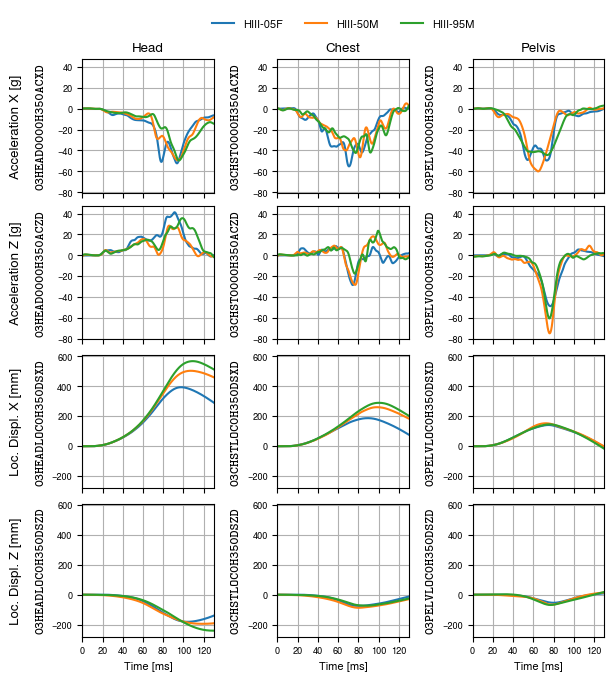

In [108]:
def plot_ab_kinematics_hiiis(
    close: bool = False,
):
    dbs = {}
    for perc in ("05", "50", "95"):
        with ZipFile(
            Path("/mnt")
            / "q"
            / "Honda_Accord_2014_Sled_with_HIII_Rigid_Seat_SpeedOpt_BigDOE"
            / "Test_Assemblies"
            / f"{perc}th_Base"
            / "extracted.csv.zip"
        ) as z:
            dbs[perc] = (pl.scan_csv(z.read("extracted.csv")).collect()).to_pandas().set_index("TIME")

    channels = [
        ["03HEAD0000H350ACXD", "03CHST0000H350ACXD", "03PELV0000H350ACXD"],
        ["03HEAD0000H350ACZD", "03CHST0000H350ACZD", "03PELV0000H350ACZD"],
        ["03HEADLOC0H350DSXD", "03CHSTLOC0H350DSXD", "03PELVLOC0H350DSXD"],
        ["03HEADLOC0H350DSZD", "03CHSTLOC0H350DSZD", "03PELVLOC0H350DSZD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1, 1, 1]
    )
    part_dict = {"HEAD": "Head", "CHST": "Chest", "PELV": "Pelvis"}

    ax[channels[1][0]].sharey(ax[channels[1][1]])
    ax[channels[1][1]].sharey(ax[channels[1][2]])
    ax[channels[1][2]].sharey(ax[channels[2][0]])
    ax[channels[2][0]].sharey(ax[channels[2][1]])
    ax[channels[2][1]].sharey(ax[channels[2][2]])

    ax[channels[3][0]].sharey(ax[channels[3][1]])
    ax[channels[3][1]].sharey(ax[channels[3][2]])
    ax[channels[3][2]].sharey(ax[channels[4][0]])
    ax[channels[4][0]].sharey(ax[channels[4][1]])
    ax[channels[4][1]].sharey(ax[channels[4][2]])

    for channel in sum(channels[1:], []):
        # iso = rating_iso_18571_short(
        #    signal_ref=dbs[ref_alt_name][channel].loc[20:120].values,
        #    signal_comp=dbs[comp_alt_name][channel].loc[20:120].values,
        # )
        # add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate(sorted(dbs.keys())):
            ax[channel].plot(
                dbs[version].index,
                dbs[version][channel],
                # c=NEW_CAES[i],
                label=f"HIII-{version}{'F' if version == '05' else 'M'}",#version.replace("_", " - "),
                # alpha=0.8,
            )

        ax[channel].set_ylabel(channel, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        if channel in channels[-1]:
            ax[channel].set_xlabel("Time [ms]")

        if channel in channels[1]:
            ax[channel].set_title(part_dict[channel[2:6]])

        if channel[2:6] == "HEAD":
            if channel[-4:-2] == "AC":
                txt = f"Acceleration {channel[-2]} [g]"
            else:
                txt = f"Loc. Displ. {channel[-2]} [mm]"

            ax[channel].annotate(txt, (-0.55, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=3)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"kinematics_hiiis.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(6.7)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_kinematics_hiiis()

2025-01-04 10:58:45,494     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 10:58:45,498     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 10:58:45,502     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 10:58:45,505     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 10:58:45,511     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 10:58:45,512     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT
2025-01-04 10:58:45,597     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2AL

2025-01-04 10:58:47,169  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/VPS_HIII_vs_VPS_VH50_ab_kinematics.pdf
2025-01-04 10:58:53,019     INFO  MainProcess  MainThread maxp pruned
2025-01-04 10:58:53,022     INFO  MainProcess  MainThread cmap pruned
2025-01-04 10:58:53,023     INFO  MainProcess  MainThread post pruned
2025-01-04 10:58:53,024     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 10:58:53,026     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 10:58:53,027     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 10:58:53,030     INFO  MainProcess  MainThread glyf pruned
2025-01-04 10:58:53,031     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 10:58:53,032     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 10:58:53,033     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 22 glyphs before
2025-01-04 10:58:53,03

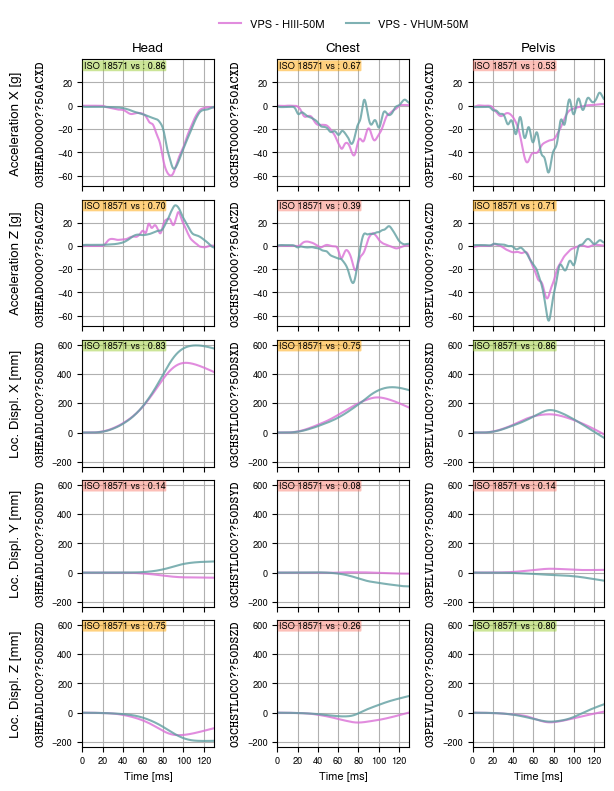

In [129]:
def plot_ab_kinematics_vh(ref: str = "LS-Dyna_HIII", comp: str = "VPS_HIII", close: bool = False):
    dbs: Dict[str, pd.DataFrame] = get_virthuman_val_data(versions=[ref, comp])
    for k in dbs.keys():
        dbs[k].rename(columns={c: c[:10] + "????" + c[-4:] for c in dbs[k].columns}, inplace=True)

    channels = [
        ["03HEAD0000????ACXD", "03CHST0000????ACXD", "03PELV0000????ACXD"],
        ["03HEAD0000????ACZD", "03CHST0000????ACZD", "03PELV0000????ACZD"],
        ["03HEADLOC0????DSXD", "03CHSTLOC0????DSXD", "03PELVLOC0????DSXD"],
        ["03HEADLOC0????DSYD", "03CHSTLOC0????DSYD", "03PELVLOC0????DSYD"],
        ["03HEADLOC0????DSZD", "03CHSTLOC0????DSZD", "03PELVLOC0????DSZD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]
    part_renamer = {"HEAD": "Head", "CHST": "Chest", "PELV": "Pelvis"}

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1, 1, 1, 1]
    )

    ax[channels[1][0]].sharey(ax[channels[1][1]])
    ax[channels[1][1]].sharey(ax[channels[1][2]])
    ax[channels[1][2]].sharey(ax[channels[2][0]])
    ax[channels[2][0]].sharey(ax[channels[2][1]])
    ax[channels[2][1]].sharey(ax[channels[2][2]])

    ax[channels[3][0]].sharey(ax[channels[3][1]])
    ax[channels[3][1]].sharey(ax[channels[3][2]])
    ax[channels[3][2]].sharey(ax[channels[4][0]])
    ax[channels[4][0]].sharey(ax[channels[4][1]])
    ax[channels[4][1]].sharey(ax[channels[4][2]])
    ax[channels[4][2]].sharey(ax[channels[5][0]])
    ax[channels[5][0]].sharey(ax[channels[5][1]])
    ax[channels[5][1]].sharey(ax[channels[5][2]])

    for channel in sum(channels[1:], []):
        iso = rating_iso_18571_short(
            signal_ref=dbs[ref][channel].loc[20:120].values,
            signal_comp=dbs[comp][channel].loc[20:120].values,
        )
        add_textbox(ax=ax[channel], j=0, f1="ISO 18571", f2="", iso=iso)

        for i, version in enumerate([ref, comp]):
            ax[channel].plot(
                dbs[version].index, dbs[version][channel], c=NEW_CAES[i], label=version.replace("_", " - ").replace("HIII", "HIII-50M").replace("VH50", "VHUM-50M"), alpha=0.8
            )

        ax[channel].set_ylabel(channel.replace("????", "??50"), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        if channel in channels[-1]:
            ax[channel].set_xlabel("Time [ms]")

        if channel in channels[1]:
            ax[channel].set_title(part_renamer[channel[2:6]])

        if channel[2:6] == "HEAD":
            if channel[-4:-2] == "AC":
                txt = f"Acceleration {channel[-2]} [g]"
            else:
                txt = f"Loc. Displ. {channel[-2]} [mm]"

            ax[channel].annotate(txt, (-0.55, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=2)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{ref}_vs_{comp}_ab_kinematics.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.3 * 6)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_kinematics_vh(ref="VPS_HIII", comp="VPS_VH50")

2025-01-04 11:04:43,524     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/original_model_dyna exists: True
2025-01-04 11:04:43,528     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_AM50_HIII_RESULT exists: True
2025-01-04 11:04:43,537     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT exists: True
2025-01-04 11:04:43,545     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT exists: True
2025-01-04 11:04:43,561     INFO  MainProcess  MainThread File /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT exists: True
2025-01-04 11:04:43,562     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AF05_RESULT


2025-01-04 11:04:43,766     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM50_RESULT
2025-01-04 11:04:43,942     INFO  MainProcess  MainThread Get data from /mnt/q/AWARE2ALL/from_esi/2024-06-27_ESI_result_files_v5/FullFrontal_VH-AM95_RESULT
2025-01-04 11:04:44,683  WARNING  MainProcess  MainThread Saved to /root/py_projects/aihiii/reports/figures/054_Eval_ValChain_THOR_HIII_vs_HIII_Speed_Corridors_Selection/VPS_VH05_vs_VPS_VH50__vs_VPS_VH95_abc_kinematics.pdf
2025-01-04 11:04:50,131     INFO  MainProcess  MainThread maxp pruned
2025-01-04 11:04:50,136     INFO  MainProcess  MainThread cmap pruned
2025-01-04 11:04:50,138     INFO  MainProcess  MainThread post pruned
2025-01-04 11:04:50,139     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 11:04:50,142     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 11:04:50,145     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 11:04:50,148     INFO  MainProces

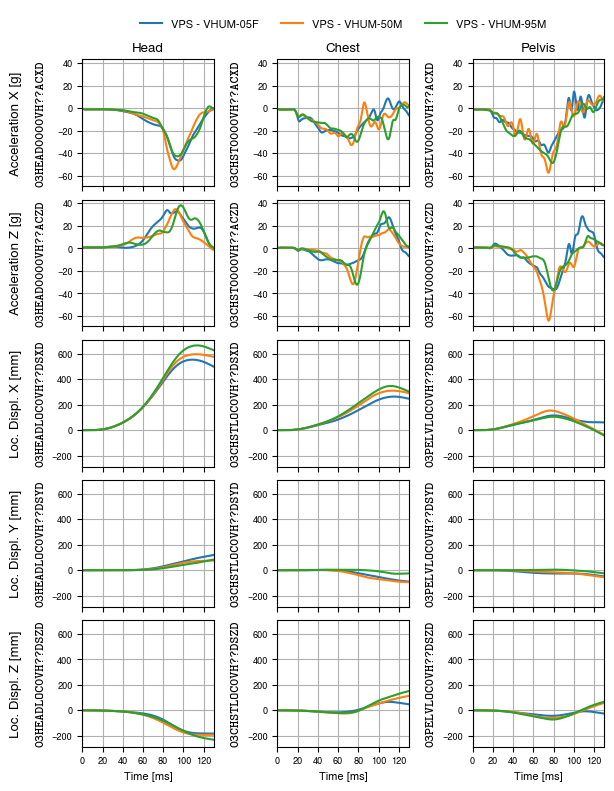

In [130]:
def plot_ab_kinematics_vh_triple(v1: str = "VPS_VH05", v2: str = "VPS_VH50", v3="VPS_VH95", close: bool = False):
    dbs: Dict[str, pd.DataFrame] = get_virthuman_val_data(versions=[v1, v2, v3])
    for k in dbs.keys():
        dbs[k].rename(columns={c: c[:10] + "????" + c[-4:] for c in dbs[k].columns}, inplace=True)

    channels = [
        ["03HEAD0000????ACXD", "03CHST0000????ACXD", "03PELV0000????ACXD"],
        ["03HEAD0000????ACZD", "03CHST0000????ACZD", "03PELV0000????ACZD"],
        ["03HEADLOC0????DSXD", "03CHSTLOC0????DSXD", "03PELVLOC0????DSXD"],
        ["03HEADLOC0????DSYD", "03CHSTLOC0????DSYD", "03PELVLOC0????DSYD"],
        ["03HEADLOC0????DSZD", "03CHSTLOC0????DSZD", "03PELVLOC0????DSZD"],
    ]
    channels = [["none"] * len(channels[0]), *channels]
    part_renamer = {"HEAD": "Head", "CHST": "Chest", "PELV": "Pelvis"}

    fig, ax = plt.subplot_mosaic(
        mosaic=channels, sharex=True, layout="constrained", height_ratios=[0.01, 1, 1, 1, 1, 1]
    )

    ax[channels[1][0]].sharey(ax[channels[1][1]])
    ax[channels[1][1]].sharey(ax[channels[1][2]])
    ax[channels[1][2]].sharey(ax[channels[2][0]])
    ax[channels[2][0]].sharey(ax[channels[2][1]])
    ax[channels[2][1]].sharey(ax[channels[2][2]])

    ax[channels[3][0]].sharey(ax[channels[3][1]])
    ax[channels[3][1]].sharey(ax[channels[3][2]])
    ax[channels[3][2]].sharey(ax[channels[4][0]])
    ax[channels[4][0]].sharey(ax[channels[4][1]])
    ax[channels[4][1]].sharey(ax[channels[4][2]])
    ax[channels[4][2]].sharey(ax[channels[5][0]])
    ax[channels[5][0]].sharey(ax[channels[5][1]])
    ax[channels[5][1]].sharey(ax[channels[5][2]])

    for channel in sum(channels[1:], []):
        for i, version in enumerate([v1, v2, v3]):
            ax[channel].plot(dbs[version].index, dbs[version][channel], label=version.replace("_", " - ").replace("VH05", "VHUM-05F").replace("VH50", "VHUM-50M").replace("VH95", "VHUM-95M"))

        ax[channel].set_ylabel(channel.replace("????", "VH??"), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
        if channel in channels[-1]:
            ax[channel].set_xlabel("Time [ms]")

        if channel in channels[1]:
            ax[channel].set_title(part_renamer[channel[2:6]])

        if channel[2:6] == "HEAD":
            if channel[-4:-2] == "AC":
                txt = f"Acceleration {channel[-2]} [g]"
            else:
                txt = f"Loc. Displ. {channel[-2]} [mm]"

            ax[channel].annotate(txt, (-0.55, 0.5), rotation=90, va="center", xycoords="axes fraction", fontsize="large")

        ax[channel].grid()
        ax[channel].set_xlim([0, 130])

    ax["none"].legend(*ax[channels[1][0]].get_legend_handles_labels(), loc="upper center", ncol=3)
    ax["none"].set_axis_off()

    f_path = FIG_DIR / f"{v1}_vs_{v2}__vs_{v3}_abc_kinematics.pdf"
    LOG.warning("Saved to %s", f_path)
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.3 * 6)
    fig.savefig(f_path)

    if close:
        plt.close(fig)


plot_ab_kinematics_vh_triple()